# Case Study Projesi: Kardiyovasküler Hastalık Tahmini
---

### Projede kullanılan teknolojiler ve kurulum:

- Proglamlama dili: `Python`   
      
- Model tracking: `MLflow`
  
- Fronthand: `Gradio`
  
- Backend: `FastAPI`
  
- Versiyon kontrol: `Git`

Kurulum:
```
git clone https://github.com/kntvrl/kodlasam_hearth_disease_project.git
cd kodlasam_hearth_disease_project
python -m venv venv
pip install -r requirements.txt
python hearth_app

Local: http://127.0.0.1:7860


```
[Proje Github Reposu](https://github.com/kntvrl/kodlasam_hearth_disease_project)


<img src="./hearth_app.png" alt="Local Image" width="1000"/>

## Proje Açıklaması
Bu projede, kardiyovasküler hastalıkları tahmin etmek için bir makine öğrenmesi modeli geliştirilecektir. Verilen veri seti, çeşitli hasta özelliklerini ve bu hastaların kardiyovasküler hastalık durumu hakkında bilgi içermektedir. Amaç, bu veri setini kullanarak hastalık tahmin doğruluğunu artırmak için gerekli veri işleme ve özellik mühendisliği adımlarını gerçekleştirmektir.

---

Kullanılacak veri seti: [Heart Disease Dataset](https://archive.ics.uci.edu/dataset/45/heart+disease)

Kurulum:
```pip install ucimlrepo```

Kullanım:
```
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
# metadata 
print(heart_disease.metadata) 
# variable information 
print(heart_disease.data.variables)
heart_disease.variables)
```

**Veri setinin Özelliklerinin açıklamaları:**

1. **Age: Yaş** - Kişinin yaşı hakkında sayısal bilgi içerir.
2. **Sex: Cinsiyet** - Kişinin cinsiyetini belirtir (1 = erkek; 0 = kadın).
3. **Chest Pain Type (4 values)** - Göğüs ağrısı türünü belirtir (1: Tipik angina, 2: Atipik angina, 3: Non-anginal ağrı, 4: Asemptomatik).
4. **Resting Blood Pressure** - Dinlenme halindeki kan basıncı (mm Hg cinsinden).
5. **Serum Cholesterol in mg/dl** - Serum kolesterol düzeyi (mg/dl cinsinden).
6. **Fasting Blood Sugar > 120 mg/dl** - Açlık kan şekeri seviyesi 120 mg/dl'nin üzerinde mi (1 = doğru; 0 = yanlış).
7. **Resting ECG results (values 0, 1, 2)** - Dinlenme halindeki elektrokardiyografi sonuçları (0: Normal, 1: ST-T dalga anormallikleri, 2: Sol ventrikül hipertrofisi veya T dalga inversiyonu).
8. **Maximum Heart Rate achieved** - Ulaşılan maksimum kalp hızı.
9. **Exercise Induced Angina** - Egzersizle indüklenen angina (1 = evet; 0 = hayır).
10. **ST depression induced by exercise relative to rest** - Egzersizle indüklenen ST segmenti depresyonu (dinlenmeye göre).
11. **Slope of the peak exercise ST segment** - Egzersiz sırasında zirve ST segmentinin eğimi (1: Yukarı eğimli, 2: Düz, 3: Aşağı eğimli).
12. **Number of major vessels (0-3) colored by fluoroscopy** - Floroskopi ile boyanmış ana damar sayısı (0-3 arası).
13. **Thal** - Talasemi durumu (3 = normal; 6 = sabit defekt; 7 = geri dönebilen defekt).

---

**Hedef değişken**: Presence of heart disease (Kalp hastalığı varlığı) - Kalp hastalığı olup olmadığını belirtir (1 = hastalık; 0 = hastalık yok).


---

**Sayısal ve kategorik özellikler**

**Sayısal özellikler**
- age: integer
- resting_blood_pressure: integer
- serum_cholesterol: integer
- maximum_heart_rate_achived
- st_depression_induced_by_exercise
- number_major_vessels

**Sayısal kategorik özellikler**
- sex
- chest_pain_type
- fasting_blood_sugar
- resting_ecg_results
- exercise_induced_angina
- thal
- slope_peak_exercise_st_segment
- presence_of_heart_disease (Target)

---


**Kütüphane importları**

In [2291]:
import warnings
from ucimlrepo import fetch_ucirepo 
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, MinMaxScaler, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score, roc_curve,auc, confusion_matrix, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

# Veri Yükleme ve Temizleme

- İlk olarak veri kaynaktan indirilmiş, ardından özellikler proje word dosyasında bulunan özellikler ile karşılaştırılıp doğrulanmış ve özelliklere proje word dosyasındaki özellik isimleri verilmiştir.
  
- Kaynaktan gelen veriler dataframe haline getirilmiştir. Kolon isimlendirmeleri yapıldıktan sonra tekrar raw_df adında csv dosyasına kaydedilmiştir. Buradaki amaç, notebook dosyasının baştan çalıştırması durumunda veriyi internetten tekrar indirmek yerine csv den okumaktır.

- Dataseti indirme

In [2292]:
# heart_disease = fetch_ucirepo(id=45)
# X = heart_disease.data.features 
# y = heart_disease.data.targets 
# df = pd.concat([X, y], axis=1)
# print("Veri seti boyutu")
# print(heart_disease.data.features.shape)
# print(heart_disease.data.targets.shape)
# print("---------------------------------")
# print("İnternetten okunan verinin kolon isimleri ve tipleri:")
# print(df.info())

- Projenin bilgilendirmelerini içeren kodlasam platformundan indirilen word dosyasındaki isimlendirme ile csv kayıt işlemi.

In [2293]:
# columns_rename_dict={
#     "age":"age",
#     "sex":"sex",
#     "cp":"chest_pain_type",
#     "trestbps":"resting_blood_pressure",
#     "chol":"serum_cholesterol",
#     "fbs":"fasting_blood_sugar",
#     "restecg":"resting_ecg_results",
#     "thalach":"maximum_heart_rate_achieved",
#     "exang":"exercise_induced_angina",
#     "oldpeak":"st_depression_induced_by_exercise",
#     "slope":"slope_peak_exercise_st_segment",
#     "ca":"number_major_vessels",
#     "thal":"thal",
#     "num":"presence_of_heart_disease"
# }
# df = df.rename(columns=columns_rename_dict)

# # hedef değişken binary tipe dönüştürüldü.
# df["presence_of_heart_disease"] = np.where(df["presence_of_heart_disease"] > 1, 1, 0)


- **num yani Presence of heart disease hedef değişkeni 5 klasdan oluşmaktadır. Canlı dersde bu değişkenin 0 ve 1 olarak değerlendirilmesi istendiği. Bu nedenle 1 üzerindeki değerlerinde yine 1 olarak alınacağı belirtildiğinden dolayı hedef  bu şekilde düzenlenmiştir.**
  
- **Ohe hot encoding yapılması gereken kategorik değişkenler bu notebookun ileri aşamalarında tespit edilmiştir.** 
  
- **Deployment için veriye label değerlerin verilmesi gerektiğinden, bu bölümde sayısal olarak ifade edilen bu sayısal kategorik değişkenlerin, etiketleme işlemi bu bölüme taşınmıştır.**

**Düzenlemelerden sonra csv olarak raw data kayıt edilmiştir.**

In [2294]:
# chest_pain_type_dict = {
#     1 :"cp_typical_angina",
#     2 :"cp_atypical_angina",
#     3 :"cp_non_anginal_pain",
#     4: "cp_asymptomatic"
# }
# df["chest_pain_type"] = df["chest_pain_type"].map(chest_pain_type_dict)

# ecg_results_dict = {
#     0: "ecg_normal",
#     1: "ecg_st_t_wave_abnormality",
#     2: "ecg_left_ventricular_hypertrophy"
# }
# df["resting_ecg_results"] = df["resting_ecg_results"].map(ecg_results_dict)

# thal_dict = {
#     3: "thal_normal",
#     6: "thal_fixed_defect",
#     7: "thal_reversable_defect"
# }
# df["thal"] = df["thal"].map(thal_dict)

# slope_dict = {
#     1: "slope_upsloping",
#     2: "slope_flat",
#     3: "slope_downsloping"
# }
# df["slope_peak_exercise_st_segment"] = df["slope_peak_exercise_st_segment"].map(slope_dict)

# df.to_csv("raw_heart_disease_data.csv", index=False)

**Verinin lokalden yüklenmesi**

In [2295]:
df = pd.read_csv("raw_heart_disease_data.csv")
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
0,63,1,cp_typical_angina,145,233,1,ecg_left_ventricular_hypertrophy,150,0,2.3,slope_downsloping,0.0,thal_fixed_defect,0
1,67,1,cp_asymptomatic,160,286,0,ecg_left_ventricular_hypertrophy,108,1,1.5,slope_flat,3.0,thal_normal,1
2,67,1,cp_asymptomatic,120,229,0,ecg_left_ventricular_hypertrophy,129,1,2.6,slope_flat,2.0,thal_reversable_defect,0
3,37,1,cp_non_anginal_pain,130,250,0,ecg_normal,187,0,3.5,slope_downsloping,0.0,thal_normal,0
4,41,0,cp_atypical_angina,130,204,0,ecg_left_ventricular_hypertrophy,172,0,1.4,slope_upsloping,0.0,thal_normal,0


In [2296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                303 non-null    int64  
 1   sex                                303 non-null    int64  
 2   chest_pain_type                    303 non-null    object 
 3   resting_blood_pressure             303 non-null    int64  
 4   serum_cholesterol                  303 non-null    int64  
 5   fasting_blood_sugar                303 non-null    int64  
 6   resting_ecg_results                303 non-null    object 
 7   maximum_heart_rate_achieved        303 non-null    int64  
 8   exercise_induced_angina            303 non-null    int64  
 9   st_depression_induced_by_exercise  303 non-null    float64
 10  slope_peak_exercise_st_segment     303 non-null    object 
 11  number_major_vessels               299 non-null    float64

**Veri 13 özellik, bir hedef özellik olmak üzere 14 kolon, 303 satırdan oluşmaktadır.**

In [2297]:
df.shape

(303, 14)

**Eksik Veri İşlemleri**
- number_major_vessels de 4 ve thal da 2 adet eksik veri tespit edilmiştir.
- Bir veri setinde bulunan eksik veriler için dünyada kabul gören %5 kuralına göre eksik veriler veri setinin %5 inden az ise bu verileri kaldırmak genelde uygulanan bir yaklaşımdır.



- Heart-disease veri setinde bu oran yaklaşık 1.98 olduğundan eksik veriler temizleniştir.
$$
\text{Eksik veri oranı} = \left(\frac{6}{303}\right) \times 100 \approx 1.98\%
$$


<Axes: >

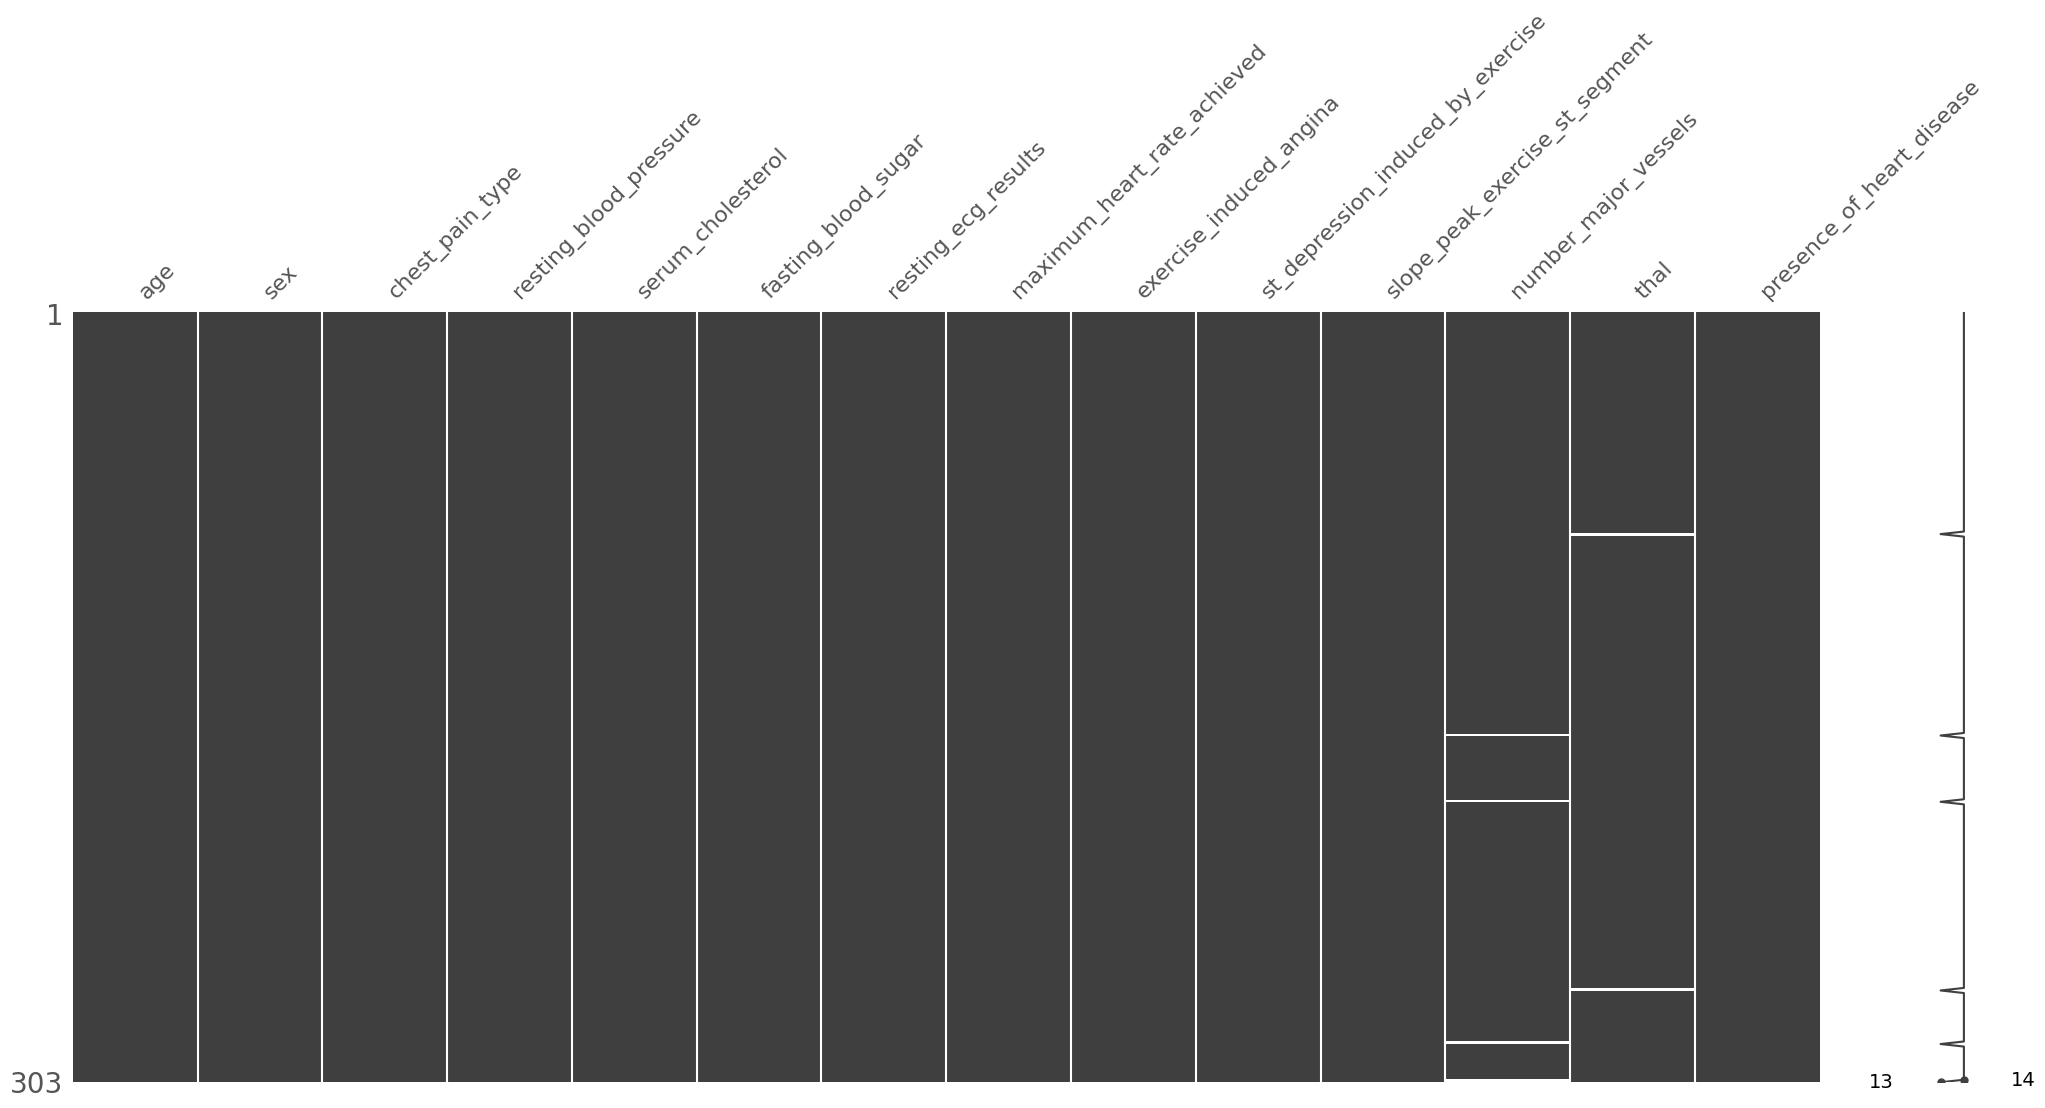

In [2298]:
msno.matrix(df)

In [2299]:
df.isnull().sum()

age                                  0
sex                                  0
chest_pain_type                      0
resting_blood_pressure               0
serum_cholesterol                    0
fasting_blood_sugar                  0
resting_ecg_results                  0
maximum_heart_rate_achieved          0
exercise_induced_angina              0
st_depression_induced_by_exercise    0
slope_peak_exercise_st_segment       0
number_major_vessels                 4
thal                                 2
presence_of_heart_disease            0
dtype: int64

In [2300]:
def clean_data(df):
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    return df

**Tekrarlanan veri kontrolü**
- Veri setinde tekrarlanan veri bulunmamaktadır.

In [2301]:
df[df.duplicated(keep=False)]

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


**Eksik verilerin temizlenmesi**

In [2302]:
clean_data(df)
df.isnull().sum()

age                                  0
sex                                  0
chest_pain_type                      0
resting_blood_pressure               0
serum_cholesterol                    0
fasting_blood_sugar                  0
resting_ecg_results                  0
maximum_heart_rate_achieved          0
exercise_induced_angina              0
st_depression_induced_by_exercise    0
slope_peak_exercise_st_segment       0
number_major_vessels                 0
thal                                 0
presence_of_heart_disease            0
dtype: int64

**Anormal değerlerin tespiti**

- Anormal değerlerin tespiti işleminden önce plotting fonksiyonu tanımlanmış veriler analiz edilmiştir.
  
- Veri setinde object veya categorical tipde veri olmadığından. Sayısal verileri görselleştirmek amaçlı yazılmıştır. Dağılımlar için histogram ve kdeplot, aykırı değer tespiti için boxplot çizimi yapılmaktadır.
  
- Dağılımlar incelenmiştir.
  
- Anormal değerlerin alt ve üst limitlerini iqr yöntemi ile tespit için fonksiyon yazılmıştır. Veri setindeki her bir sayısal özellik için girilen eşik değere göre alt ve üst limitleri geri dönmektedir. Yine tespit edilen aykırı değerlerin baskılanması için fonksiyon yazılmıştır. Ayrıca describe ve outliers'i göstermek için kolaylaştırıcı fonksiyonlar yazılmıştır.
  
-  Tespit edilen aykırı değerler alt limit yada üst limit değerlerine baskılanmıştır.
  
-  Sayısal kategorik değişkenlerin sınıfları veri setinden kontrol edilip doğrulamaları yapılmıştır.

**Fonksiyon tanımlamaları**

In [2303]:
def plot_features(df,types=["int64","float64"]):
   numeric_columns= [col for col in df.columns if df[col].dtype in types]
   for i in numeric_columns:
      fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
      sns.histplot(x=df[i],bins=10,ax=axes[0])
      axes[0].set_title(i)
      sns.boxplot(x=df[i],ax=axes[1])
      axes[1].set_title(i)
      sns.kdeplot(x=df[i],ax=axes[2])
      axes[2].set_title(i)
      plt.show()

In [2304]:
def custom_barplot(df, categoric_value, numeric_value, agg_func):
    sorted_df = df.groupby(categoric_value)[numeric_value].agg(agg_func).reset_index().sort_values(numeric_value, ascending=False)
    sns.barplot(x=categoric_value, y=numeric_value, data=df, estimator=agg_func, order=sorted_df[categoric_value], ci=False)
    plt.xticks(rotation=90)
    plt.show()
    return sorted_df

In [2305]:

def outlier_thresholds(df, variable, q1_thr=0.25, q3_thr=0.75):
    quartile1 = df[variable].quantile(q1_thr)
    quartile3 = df[variable].quantile(q3_thr)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    print(f"low_limit: {low_limit}, up_limit: {up_limit}")
    return low_limit, up_limit

In [2306]:
# Aykırı değer tespitinde otomatik olarak aykırı değerleri baskılama yapar. Özelliğin minimum değeri 0 low_limit değerininde negatif olduğu durumda low limit baskılaması yapılmaz.
def replace_with_thresholds(df, variable):
    low_limit, up_limit = outlier_thresholds(df, variable)
    num_replacements_upper = df[df[variable] > up_limit][variable].count()
    num_replacements_lower = df[df[variable] < low_limit][variable].count()
    
    df.loc[df[variable] > up_limit, variable] = up_limit
    if df[variable].min() > 0:
        df.loc[df[variable] < low_limit, variable] = low_limit
    
    print(f"{num_replacements_upper} değer üst limite, {num_replacements_lower} değer alt limite baskılanmıştır.")
    return df

In [2307]:
def describe_feature(df, feature):
    print(f"Veri tipi: {df[feature].dtypes}")
    return df[[feature]].describe().T

In [2308]:
def describe_categorical_feature(df, feature, normalize=False):
    print(f"Veri tipi: {df[feature].dtypes}")
    return df[feature].value_counts(normalize=normalize).reset_index()

In [2309]:
def show_outliers(df, feature, low_limit, up_limit, head_num = 5):
    df = df[(df[feature] < low_limit) | (df[feature] > up_limit)]
    print(f"Veri setinde {len(df)} adet aykırı değer bulunmaktadır.")
    return df.head(head_num)

**Sayısal özellikler**

In [2310]:
numeric_features = [
    "age",
    "resting_blood_pressure",
    "serum_cholesterol",
    "maximum_heart_rate_achieved",
    "st_depression_induced_by_exercise",
    "number_major_vessels"
]

In [2311]:
df[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
resting_blood_pressure,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
serum_cholesterol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
maximum_heart_rate_achieved,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
st_depression_induced_by_exercise,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2
number_major_vessels,297.0,0.676768,0.938965,0.0,0.0,0.0,1.0,3.0


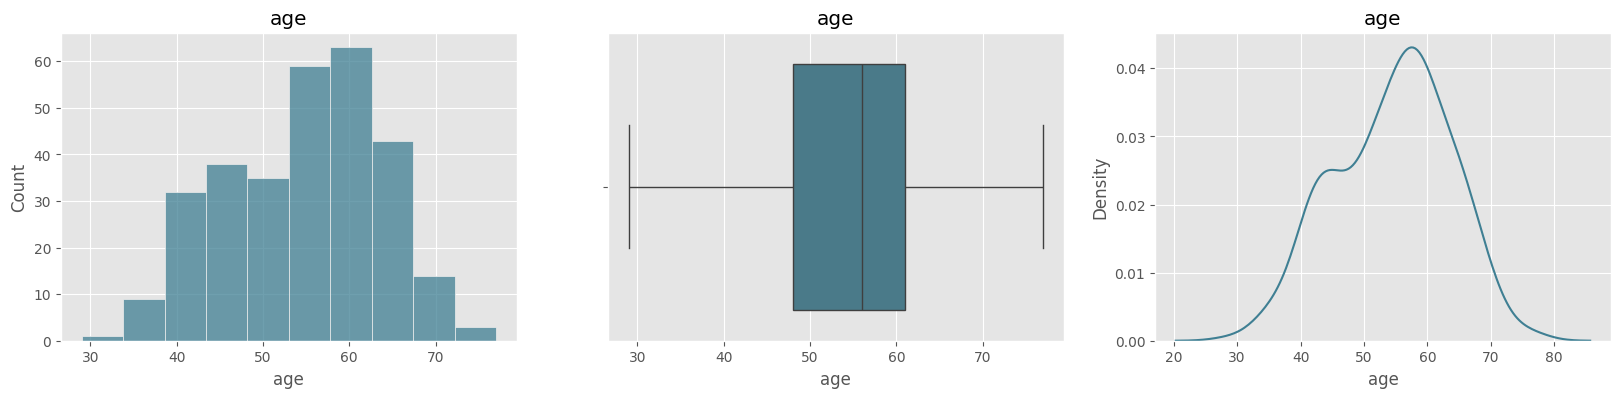

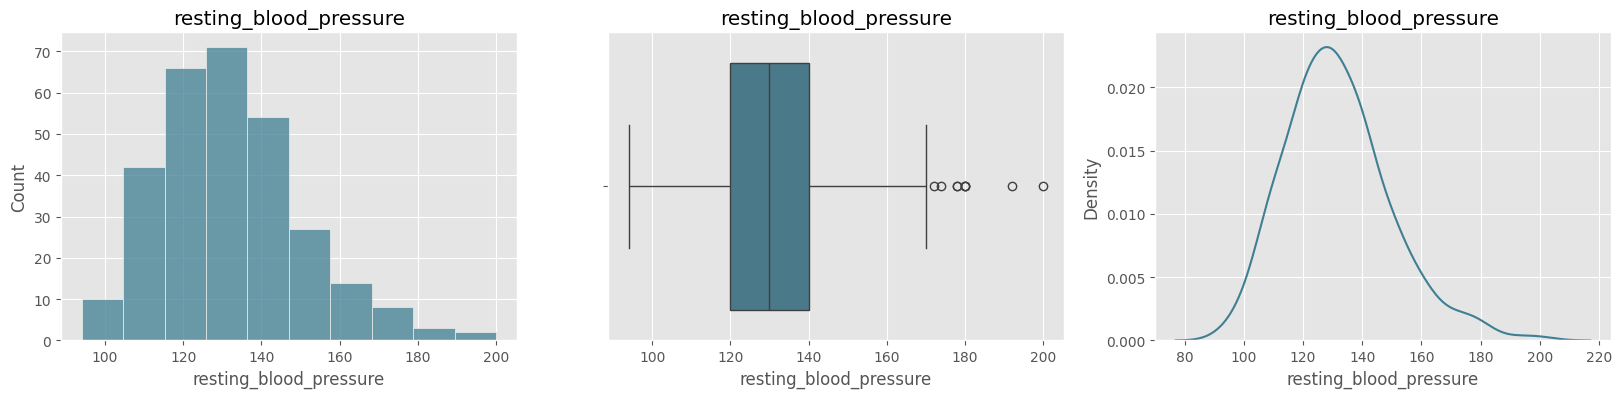

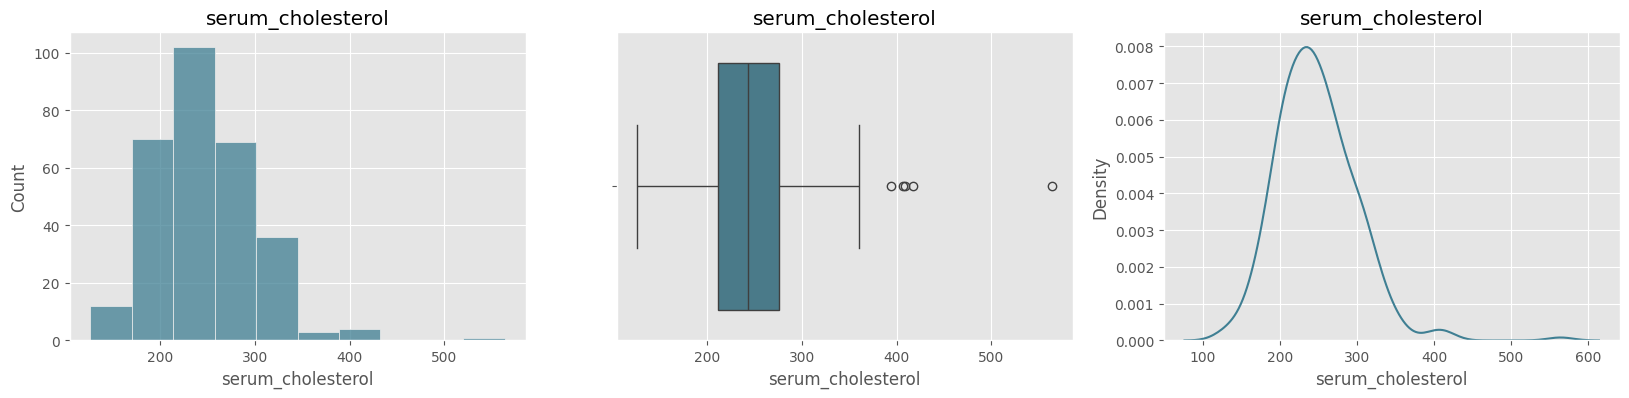

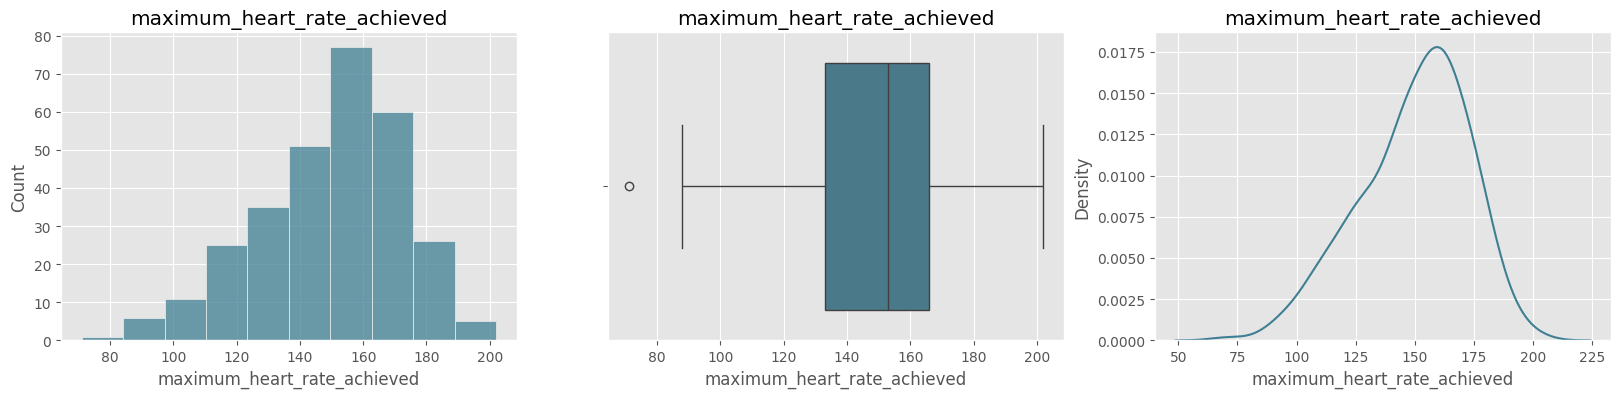

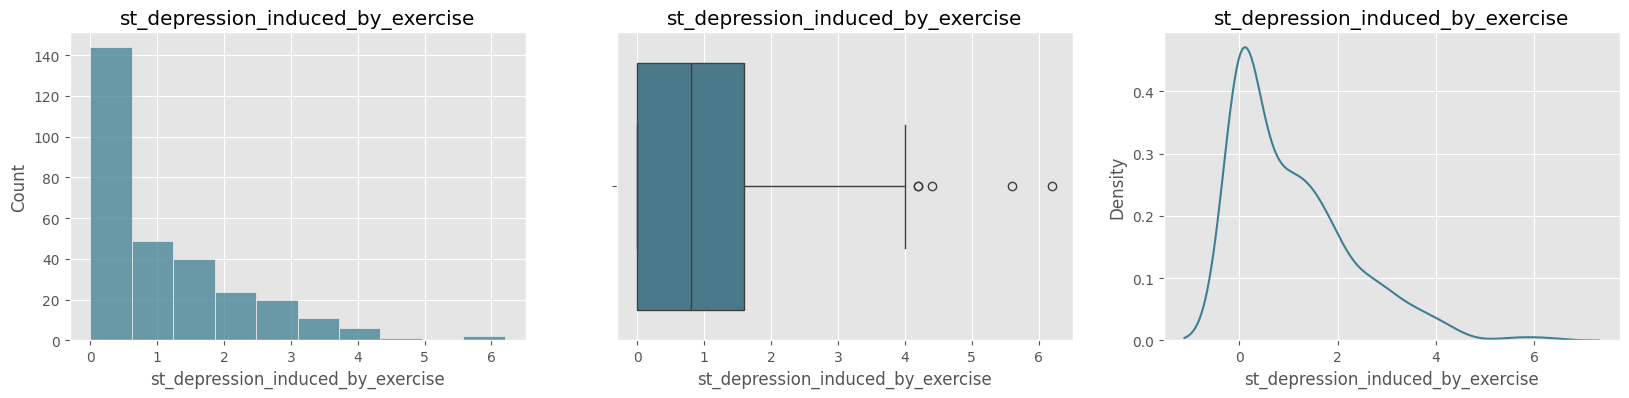

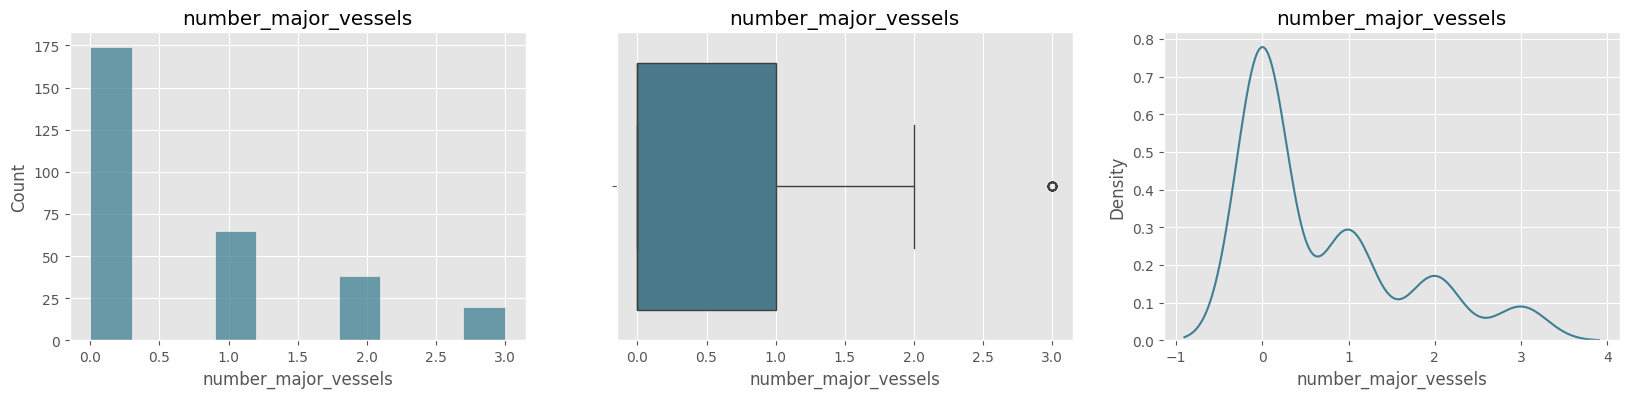

In [2312]:
plot_features(df[numeric_features])

**Dağılımlar incelendiğinde age, resting bolood pressure özelliklerinin normale yakın dağıldığı, serum cholesterolun hafif sağa çarpık olduğu, maximum healt rate achived hafif sola çarpık olduğu, st_depression induced by exercise yüksek oranda sağa çarpık olduğu gözlemlenmiştir.**

**Değişkenlerin özet istatistikleri mean ve medyan değerleri incelendiğindede bu durum gözlenmektedir.**

**Age**

- Age değişkenindeki değerler normal görünmektedir aykırı değer bulunmamaktadır.

In [2313]:
describe_feature(df, "age")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0


In [2314]:
low_limit, up_limit = outlier_thresholds(df, "age")
show_outliers(df,"age", low_limit, up_limit)

low_limit: 28.5, up_limit: 80.5
Veri setinde 0 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


In [2315]:
df = replace_with_thresholds(df, "age")

low_limit: 28.5, up_limit: 80.5
0 değer üst limite, 0 değer alt limite baskılanmıştır.


**Resting blood pressure**

- Üst limit değerinin üzerinde 9 adet aykırı değer tespit edilmiş ve üst limit değerine baskılanmıştır.

In [2316]:
describe_feature(df,"resting_blood_pressure")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
resting_blood_pressure,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0


In [2317]:
low_limit, up_limit = outlier_thresholds(df, "resting_blood_pressure")
show_outliers(df,"resting_blood_pressure", low_limit, up_limit)

low_limit: 90.0, up_limit: 170.0
Veri setinde 9 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
14,52.0,1,cp_non_anginal_pain,172,199,1,ecg_normal,162,0,0.5,slope_upsloping,0.0,thal_reversable_defect,0
83,68.0,1,cp_non_anginal_pain,180,274,1,ecg_left_ventricular_hypertrophy,150,1,1.6,slope_flat,0.0,thal_reversable_defect,1
126,56.0,0,cp_asymptomatic,200,288,1,ecg_left_ventricular_hypertrophy,133,1,4.0,slope_downsloping,2.0,thal_reversable_defect,1
172,59.0,0,cp_asymptomatic,174,249,0,ecg_normal,143,1,0.0,slope_flat,0.0,thal_normal,0
183,59.0,1,cp_typical_angina,178,270,0,ecg_left_ventricular_hypertrophy,145,0,4.2,slope_downsloping,0.0,thal_reversable_defect,0


In [2318]:
# Aykırı değer baskılama.
df = replace_with_thresholds(df, "resting_blood_pressure")

low_limit: 90.0, up_limit: 170.0
9 değer üst limite, 0 değer alt limite baskılanmıştır.


**serum_cholesterol**

- Üst limit değerinin üzerinde 5 adet aykırı değer tespit edilmiş ve üst limit değerine baskılanmıştır.

In [2319]:
describe_feature(df,"serum_cholesterol")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
serum_cholesterol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0


In [2320]:
low_limit, up_limit = outlier_thresholds(df, "serum_cholesterol")
show_outliers(df,"serum_cholesterol", low_limit, up_limit)

low_limit: 113.5, up_limit: 373.5
Veri setinde 5 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
48,65.0,0,cp_non_anginal_pain,140,417,1,ecg_left_ventricular_hypertrophy,157,0,0.8,slope_upsloping,1.0,thal_normal,0
121,63.0,0,cp_asymptomatic,150,407,0,ecg_left_ventricular_hypertrophy,154,0,4.0,slope_flat,3.0,thal_reversable_defect,1
152,67.0,0,cp_non_anginal_pain,115,564,0,ecg_left_ventricular_hypertrophy,160,0,1.6,slope_flat,0.0,thal_reversable_defect,0
173,62.0,0,cp_asymptomatic,140,394,0,ecg_left_ventricular_hypertrophy,157,0,1.2,slope_flat,0.0,thal_normal,0
181,56.0,0,cp_asymptomatic,134,409,0,ecg_left_ventricular_hypertrophy,150,1,1.9,slope_flat,2.0,thal_reversable_defect,1


In [2321]:
# Aykırı değer baskılama.
df = replace_with_thresholds(df, "serum_cholesterol")

low_limit: 113.5, up_limit: 373.5
5 değer üst limite, 0 değer alt limite baskılanmıştır.


**maximum_heart_rate_achieved**

- Alt limit değerinin altında 1 adet aykırı değer tespit edilmiş ve alt limit değerine baskılanmıştır.

In [2322]:
describe_feature(df,"maximum_heart_rate_achieved")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
maximum_heart_rate_achieved,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0


In [2323]:
low_limit, up_limit = outlier_thresholds(df, "maximum_heart_rate_achieved")
show_outliers(df,"maximum_heart_rate_achieved", low_limit, up_limit)

low_limit: 83.5, up_limit: 215.5
Veri setinde 1 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
245,67.0,1,cp_asymptomatic,120,237.0,0,ecg_normal,71,0,1.0,slope_flat,0.0,thal_normal,1


In [2324]:
# Aykırı değer baskılama.
df = replace_with_thresholds(df, "maximum_heart_rate_achieved")

low_limit: 83.5, up_limit: 215.5
0 değer üst limite, 1 değer alt limite baskılanmıştır.


**st_depression_induced_by_exercise**

- Üst limit değerinin üzerinde 5 adet aykırı değer tespit edilmiş ve üst limit değerine baskılanmıştır.

In [2325]:
describe_feature(df,"st_depression_induced_by_exercise")

Veri tipi: float64


,count,mean,std,min,25%,50%,75%,max
st_depression_induced_by_exercise,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


In [2326]:
low_limit, up_limit = outlier_thresholds(df, "st_depression_induced_by_exercise")
show_outliers(df,"st_depression_induced_by_exercise", low_limit, up_limit)

low_limit: -2.4000000000000004, up_limit: 4.0
Veri setinde 5 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
91,62.0,0,cp_asymptomatic,160,164.0,0,ecg_left_ventricular_hypertrophy,145.0,0,6.2,slope_downsloping,3.0,thal_reversable_defect,1
123,55.0,1,cp_asymptomatic,140,217.0,0,ecg_normal,111.0,1,5.6,slope_downsloping,0.0,thal_reversable_defect,1
183,59.0,1,cp_typical_angina,170,270.0,0,ecg_left_ventricular_hypertrophy,145.0,0,4.2,slope_downsloping,0.0,thal_reversable_defect,0
191,51.0,1,cp_asymptomatic,140,298.0,0,ecg_normal,122.0,1,4.2,slope_flat,3.0,thal_reversable_defect,1
285,58.0,1,cp_asymptomatic,114,318.0,0,ecg_st_t_wave_abnormality,140.0,0,4.4,slope_downsloping,3.0,thal_fixed_defect,1


In [2327]:
# Aykırı değer baskılama.
df = replace_with_thresholds(df, "st_depression_induced_by_exercise")

low_limit: -2.4000000000000004, up_limit: 4.0
5 değer üst limite, 0 değer alt limite baskılanmıştır.


**number_major_vessels**

- 0 ile 3 arasında değer alan floroskopi ile tespit edilmiş damar sayısını ifade eden kesikli sayısal değişkendir. Damar sayısının 0 ile 3 arası değer aldığı doğrulanmıştır.

In [2328]:
describe_categorical_feature(df, "number_major_vessels")

Veri tipi: float64


,number_major_vessels,count
0,0.0,174
1,1.0,65
2,2.0,38
3,3.0,20


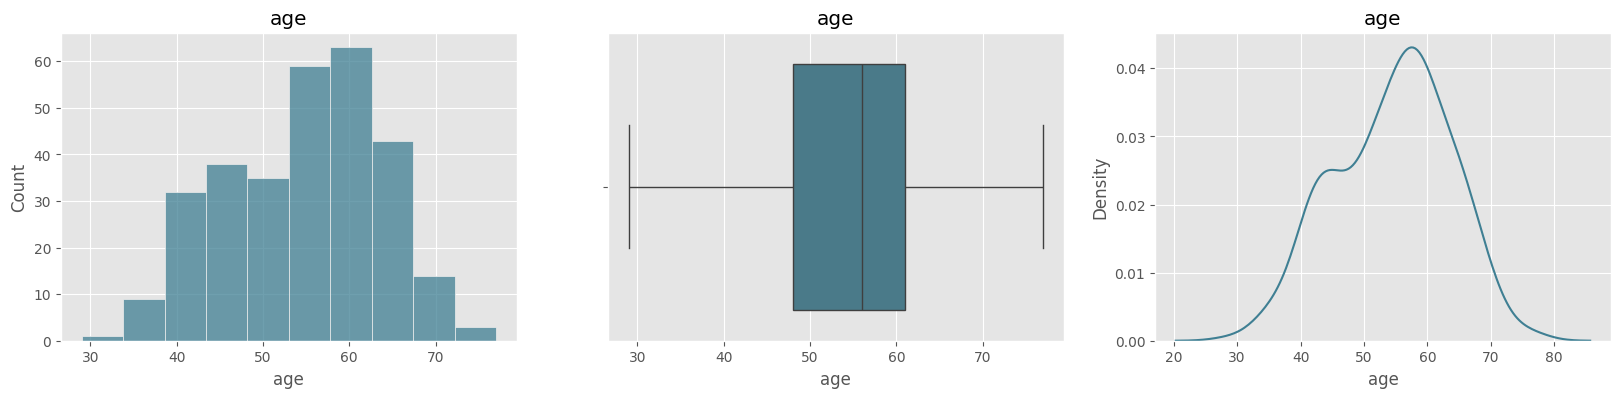

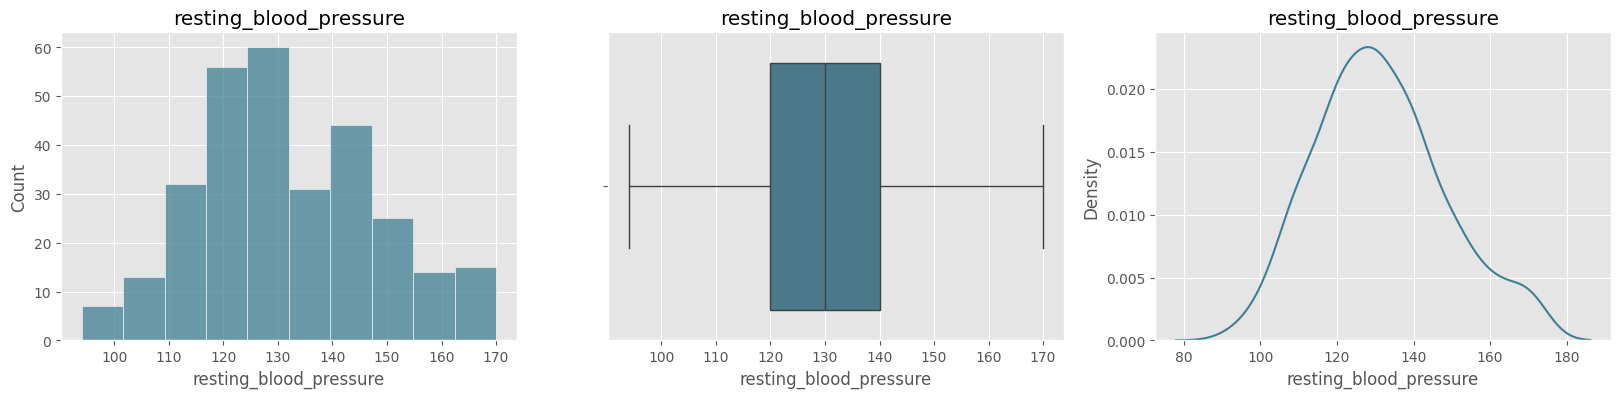

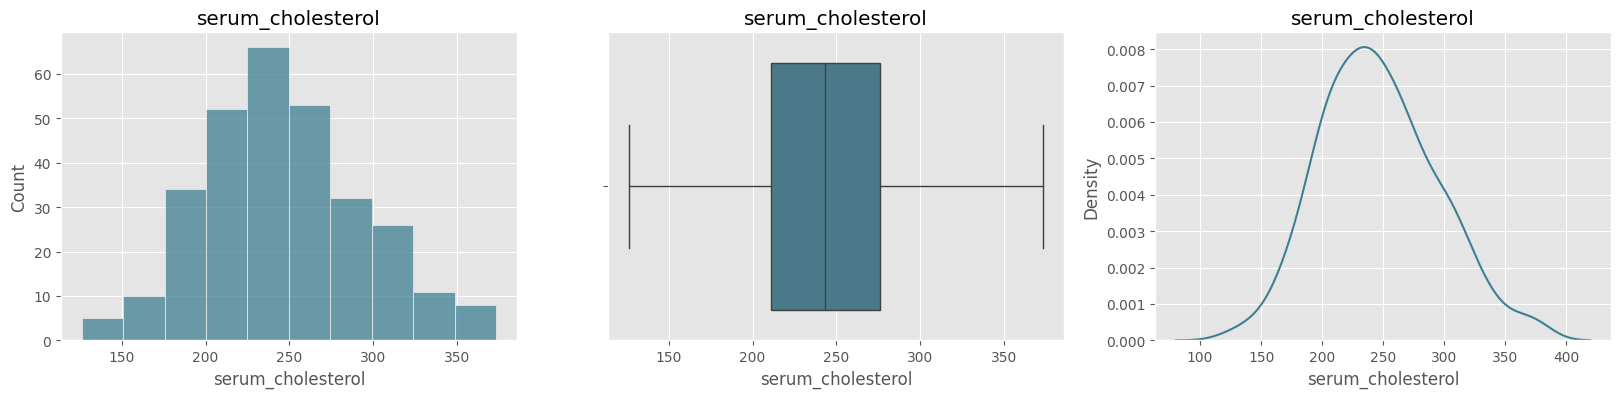

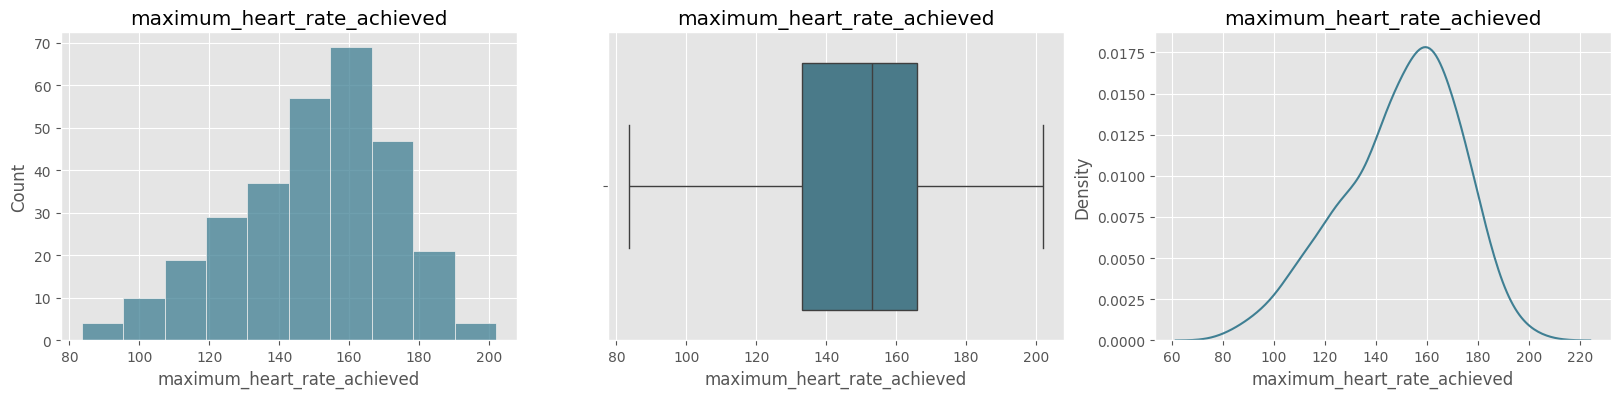

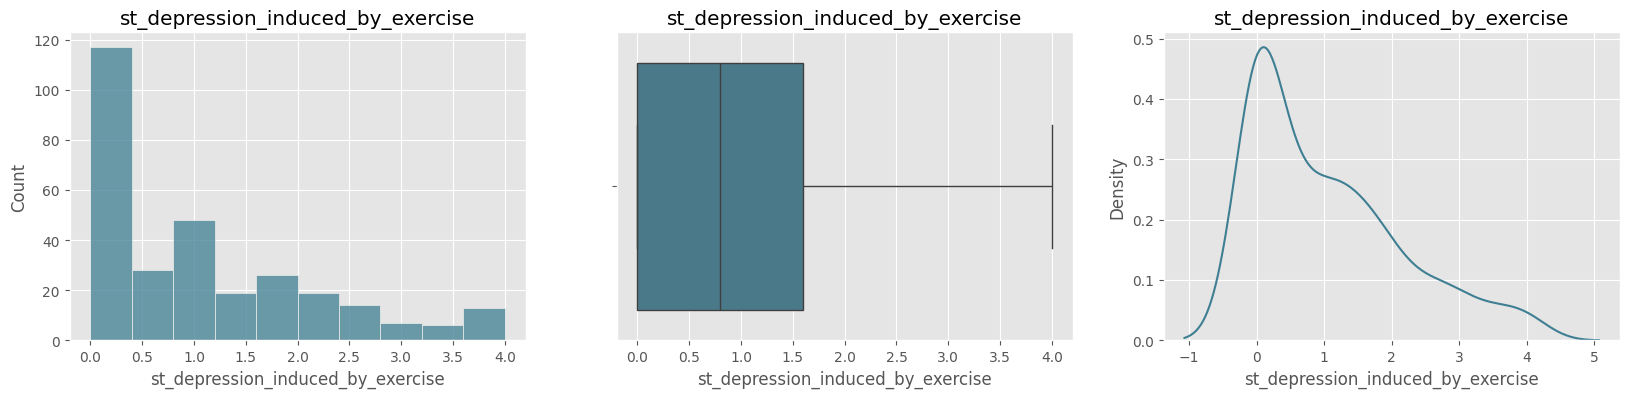

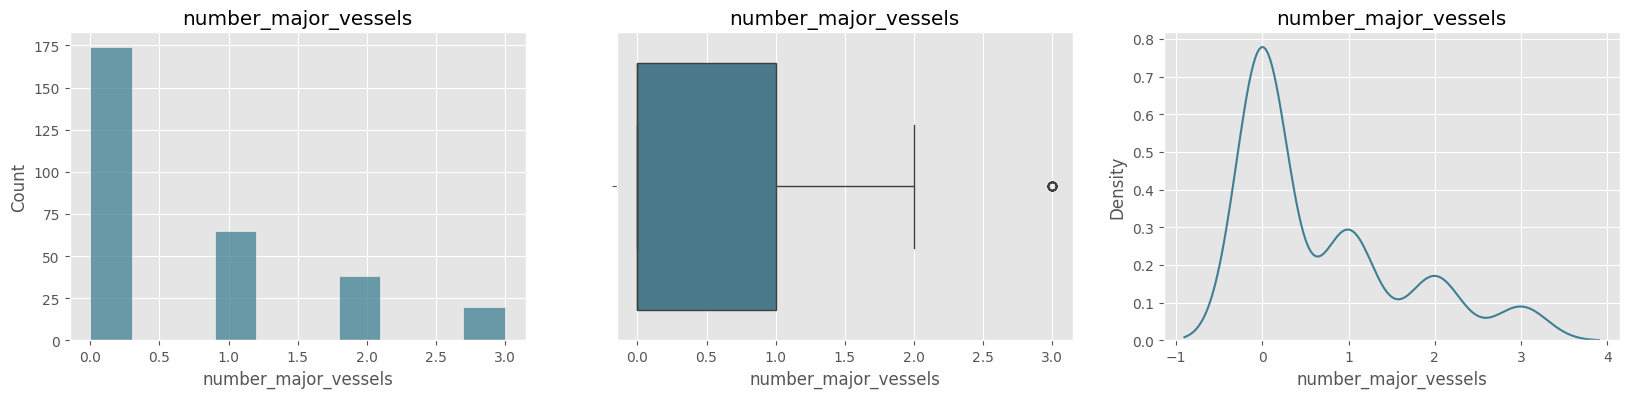

In [2329]:
plot_features(df[numeric_features])

- **Aykırı değer işlemleri neticesinde dağılımlarda azda olsa düzelmeler gözlemlenmiştir. Özellikle serum cholestrol özelliği normale yaklaşmıştır.**
- **Sağa ve sola çarpık verilerin olduğu bu datasette model performanslarını artırmak amacı ile modelleme aşamasında scaling(ölçekleme) yapılacaktır.**

**Sayısal kategorik değişkenlerin doğrulaması**
- Kategorilerde farklı bir değer yoktur. Doğrulama yapılmıştır.

In [2330]:
numeric_categorical_features = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_ecg_results",
    "exercise_induced_angina",
    "thal",
    "slope_peak_exercise_st_segment",
    "presence_of_heart_disease"
]

In [2331]:
for feature in numeric_categorical_features:
    print(df[[feature]].value_counts())

sex
1      201
0       96
Name: count, dtype: int64
chest_pain_type    
cp_asymptomatic        142
cp_non_anginal_pain     83
cp_atypical_angina      49
cp_typical_angina       23
Name: count, dtype: int64
fasting_blood_sugar
0                      254
1                       43
Name: count, dtype: int64
resting_ecg_results             
ecg_normal                          147
ecg_left_ventricular_hypertrophy    146
ecg_st_t_wave_abnormality             4
Name: count, dtype: int64
exercise_induced_angina
0                          200
1                           97
Name: count, dtype: int64
thal                  
thal_normal               164
thal_reversable_defect    115
thal_fixed_defect          18
Name: count, dtype: int64
slope_peak_exercise_st_segment
slope_upsloping                   139
slope_flat                        137
slope_downsloping                  21
Name: count, dtype: int64
presence_of_heart_disease
0                            214
1                             83
N

# Feature Engineering

**Kategorik değişkenlerin encode edilmesi**

- Kategorik değişkenler tek tek incelenip uygun encoding metodları uygulanmıştır.

**Sex**

- Erken ve kadın değerleri veri setinde  0 ve 1 olarak encode edilmiş haldedir. İlave bir işlem yapılmamıştır

In [2332]:
describe_categorical_feature(df, "sex")

Veri tipi: int64


,sex,count
0,1,201
1,0,96


**Chest pain type**

- Göğus ağrısı tiplerini ifade eder. Açıklamalardan görüldüğü üzere göğüs ağrısı tipleri arasında büyüklük küçüklük ilişkisi yoktur. Bunlar nominal kategorik değişkenlerdir. Bu nedenle one hot encoding yönteminin uygulanması daha uygun olacaktır.

- **1: Typical angina (Tipik anjina)**: 
    - Genellikle fiziksel aktivite veya stres sırasında ortaya çıkan ve dinlenme veya nitrogliserin ile hafifleyen göğüs ağrısı.
    - Kalp ile ilgili olduğu düşünülür.
- **2: Atypical angina (Atipik anjina)**: 
    - Tipik anjinaya benzer ancak semptomlar ve tetikleyiciler açısından farklılık gösterir.
    - Kalp ile ilgili olabilir veya olmayabilir.
- **3: Non-anginal pain (Non-anjiinal ağrı)**: 
    - Göğüs ağrısı, ancak tipik anjinaya benzemeyen ve genellikle kalp ile ilgili olmayan ağrılar.
    - Örneğin, kas veya iskelet sistemi kaynaklı olabilir.
- **4: Asymptomatic (Asemptomatik)**: 
    - Göğüs ağrısı olmadan kalp hastalığı veya benzeri durumlardır.

In [2333]:
describe_categorical_feature(df, "chest_pain_type")

Veri tipi: object


,chest_pain_type,count
0,cp_asymptomatic,142
1,cp_non_anginal_pain,83
2,cp_atypical_angina,49
3,cp_typical_angina,23


In [2334]:
category_one_hot = pd.get_dummies(df["chest_pain_type"]).astype(int)
df.drop("chest_pain_type", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**fasting_blood_sugar**

- Açlık kan şekeri değeri > 120 mg/dl üzerinde ise 1 değilse 0 olarak kodlanmış haldedir. İlave işleme gerek görülmemiştir.

In [2335]:
describe_categorical_feature(df, "fasting_blood_sugar")

Veri tipi: int64


,fasting_blood_sugar,count
0,0,254
1,1,43


**resting_ecg_results**

- Dinlenme EKG sonuçlarını ifade eder. Açıklamalardan görüldüğü üzere arasında büyüklük küçüklük ilişkisi yoktur. Bunlar nominal kategorik değişkenlerdir. Bu nedenle one hot encoding yönteminin uygulanması daha uygun olacaktır.

**0: Normal**:
- Kalp elektrokardiyogramında (EKG) herhangi bir anormallik göstermeyen, normal bir ST-T dalga şekli.

**1: ST-T Dalga Anormalliği**:
- ST-T dalgasında anormallikler bulunur; bu, T dalgası inversiyonu ve/veya ST segmentinde > 0.05 mV yükselme veya çöküşü içerebilir.

**2: Muhtemel veya Kesin Sol Ventrikül Hipertrofisi**:
- Estes kriterlerine göre sol ventrikül hipertrofisini gösteren bir EKG bulgusudur.

In [2336]:
describe_categorical_feature(df, "resting_ecg_results")

Veri tipi: object


,resting_ecg_results,count
0,ecg_normal,147
1,ecg_left_ventricular_hypertrophy,146
2,ecg_st_t_wave_abnormality,4


In [2337]:
category_one_hot = pd.get_dummies(df["resting_ecg_results"]).astype(int)
df.drop("resting_ecg_results", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**exercise_induced_angina**

- Egzersiz sonucu ortaya çıkan anjina (göğüs ağrısı). Bu, fiziksel aktivite sırasında göğüs ağrısının meydana gelmesini ifade eder. Egzersiz sonrası ağrı varsa 1 yoksa 0 olarak kodlandığından ilave işlem yapılmamıştır.

In [2338]:
describe_categorical_feature(df, "exercise_induced_angina")

Veri tipi: int64


,exercise_induced_angina,count
0,0,200
1,1,97


**thal**

**thal:** Thallium stres testi sonuçlarını ifade eder. Bu test, kalp kasının kan akışını ve oksijenlenmesini değerlendirmek için kullanılır. Test, kalp kasının bazı bölgelerinde kan akışının yeterliliğini incelemek amacıyla yapılır. Aralarında büyüklük küçüklük ilişkisi yoktur. Bunlar nominal kategorik değişkenlerdir. Bu nedenle one hot encoding yönteminin uygulanması daha uygun olacaktır.

**Thallium Stresi Testi Sonuçları:**

**3: Normal**:
- Kalp kasının kan akışında herhangi bir anormallik göstermeyen durumudur.

**6: Sabit Defekt**:
- Kalp kasında egzersiz veya ilaç tedavisi ile iyileşmeyen kalıcı bir defekt veya hasardır. Bu, kalpteki belirli bölgelerde kalıcı bir bozukluğu ifade eder.

**7: Geri Dönüşlü Defekt**:
- Kalp kasında egzersiz veya ilaç tedavisi sonrası iyileşebilen geçici bir defekt veya hasardır. Bu, tedavi veya egzersiz sonrası düzelebilen bir bozukluğu ifade eder.

In [2339]:
describe_categorical_feature(df, "thal")

Veri tipi: object


,thal,count
0,thal_normal,164
1,thal_reversable_defect,115
2,thal_fixed_defect,18


In [2340]:
category_one_hot = pd.get_dummies(df["thal"]).astype(int)
df.drop("thal", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**slope_peak_exercise_st_segment**

Egzersiz sırasında ST segmentinin eğiminin EKG üzerinde değişikliklerini ölçer. ST segmentinin fiziksel aktiviteye nasıl yanıt verdiğini değerlendirmeye yardımcı olur. Yine one hot encoding ile encode etmek uygun olacaktır.


**1: Upsloping**:
- ST segmentin egzersiz sırasında yukarı doğru eğimli olduğu durum. Genellikle iyi bir kalp kası kan akışını ve uygun kalp fonksiyonunu gösterir.

**2: Flat**:
- ST segmentin egzersiz sırasında düz olduğu durum. Bu, kalp kasında yeterli kan akışı olup olmadığını anlamak için dikkatli değerlendirilmesi gereken bir durumdur.

**3: Downsloping**:
- ST segmentin egzersiz sırasında aşağıya doğru eğimli olduğu durum. Genellikle kalp kasında potansiyel bir sorun veya oksijen yetersizliği işareti olabilir.

In [2341]:
describe_categorical_feature(df, "slope_peak_exercise_st_segment")

Veri tipi: object


,slope_peak_exercise_st_segment,count
0,slope_upsloping,139
1,slope_flat,137
2,slope_downsloping,21


In [2342]:
category_one_hot = pd.get_dummies(df["slope_peak_exercise_st_segment"]).astype(int)
df.drop("slope_peak_exercise_st_segment", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**`presence_of_heart_disease` (Hedef özellik)**:

- **0**: Kalp hastalığı yok.
- **1**: Kalp hastalığı var.

In [2343]:
describe_categorical_feature(df, "presence_of_heart_disease")

Veri tipi: int64


,presence_of_heart_disease,count
0,0,214
1,1,83


**Encoding işlemleri tamamlanmıştır.**

In [2344]:
df.head()

,age,sex,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,number_major_vessels,presence_of_heart_disease,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,ecg_left_ventricular_hypertrophy,ecg_normal,ecg_st_t_wave_abnormality,thal_fixed_defect,thal_normal,thal_reversable_defect,slope_downsloping,slope_flat,slope_upsloping
0,63.0,1,145,233.0,1,150.0,0,2.3,0.0,0,0,0,0,1,1,0,0,1,0,0,1,0,0
1,67.0,1,160,286.0,0,108.0,1,1.5,3.0,1,1,0,0,0,1,0,0,0,1,0,0,1,0
2,67.0,1,120,229.0,0,129.0,1,2.6,2.0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
3,37.0,1,130,250.0,0,187.0,0,3.5,0.0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
4,41.0,0,130,204.0,0,172.0,0,1.4,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


**Faeture Extraction (Özellik Çıkarımı)**

- Buradaki değişkenler, bütün preprocess ve encodingler yapılıp baseline model oluşturduktan sonra yapılmıştır. Sürecin yönetimini kolaylaştırmak için, her çıkarılan özellik sonrası model performansı değerlendirilip mlflow'a kaydedilmiştir. Ayrıca git versiyon kontrol sistemi ilede her değişken için commit yapılmıştır.
  
- Özellik çıkarımı modelin performansını artırmak amacı ile yapılır. Projede oluşturulan modeller hazırdaki özellikler ile çok yüksek skorlar elde etmişlerdir. Veri sayısı çok azdır. Normalde her yeni özellik ekleneceği zaman veri sayısının artırılması yaygın kullanılan bir uygulamadır. Bu projede mevcut veriler ile yüksek skorlar elde edildiğinden. Eklenecek her bir özellik overfitting yani aşırı oğrenme sorununa yol açabilir.

**Age kategorik değişken oluşturulması**

- Yaş değişkeni ile hedef değişken arasındaki ilişki her zaman lineer olmayabilir. Örneğin, projemizde bir yaş grubundaki bireylerin sağlık durumları gençden yaşlıya doğru farklılık gösterebilir.
- Kategorik yaş grupları, modelin belirli yaş aralıkları içindeki desenleri daha iyi öğrenmesini sağlayabilir. Bu, modelin doğruluğunu ve genelleme yeteneğini artırabilir.
- Yaş verileri genellikle belirli aralıklarda yoğunlaşabilir ve bu, modelin performansını etkileyebilir. Kategorik değişkenlere ayırmak, bu yoğunlaşmayı azaltabilir ve veriyi daha dengeli hale getirebilir
- Bu gibi nedenlerden dolayı kategorik yaş değişeni oluşturulmuştur.
- Yaş aralıkları 0-18, 18-40, 40,60 ve 60 dan sonrası olarak belirlenmiştir ve büyüklük küçüklük ifade eden ordinal kategorik değişken olarak 0, 1, 2, 3 olarak kodlanmıştır.
- 0-18 yaş kategorisi veri setinde bulunmamaktadır.

In [2345]:
age_bins = [-np.inf, 18, 40, 60, np.inf]
age_labels = [0, 1, 2, 3]
df['age_category'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [2346]:
describe_categorical_feature(df, "age_category")

Veri tipi: category


,age_category,count
0,2,201
1,3,79
2,1,17
3,0,0


- Veri setinde 40 - 60 yaş gruplarındaki insanlar yoğunluktadır.

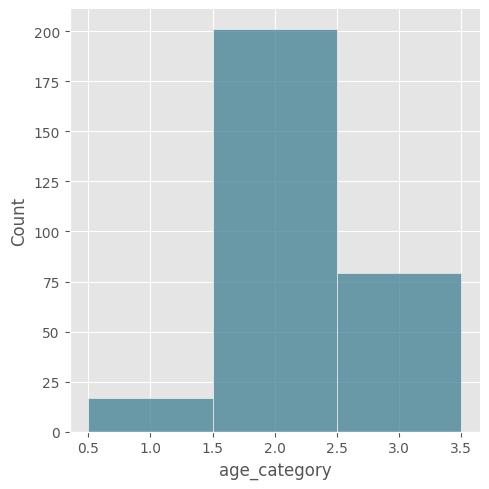

In [2347]:
sns.displot(data=df, x='age_category')

- Kalp hastası olanların yoğunluklu olarak 60 yaş sonrası yaşlı grupda olduğu görülmektedir.

In [2348]:
df.groupby("age_category")["presence_of_heart_disease"].mean().head().reset_index()

,age_category,presence_of_heart_disease
0,0,NaN
1,1,0.176471
2,2,0.248756
3,3,0.379747


**Yeni oluşturulan yaş kategorik özelliğinin sayısal özellikler ile karşılaştırılması.**

 - Elimizdeki veri setine göre. 
- resting_blood_pressure ve serum_cholesterol değerleri birbirine yakın olup yaşlıya doğru gittikçe artmaktadır.
- maximum_heart_rate_achieved 18-40 arası grupda en yüksek seviyededir.
- st_depression_induced_by_exercise, number_major_vessels değerleri 60 yaş üstü grupda daha yoğundur.

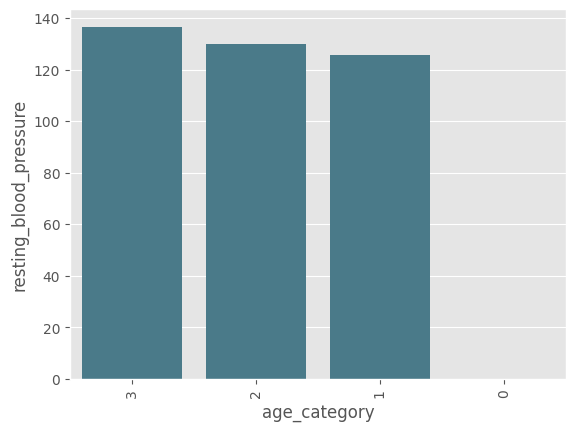

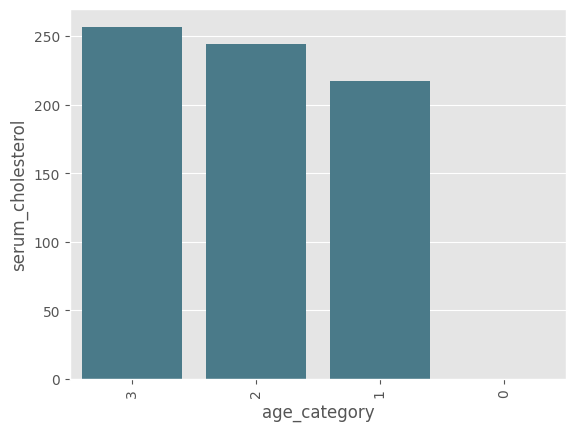

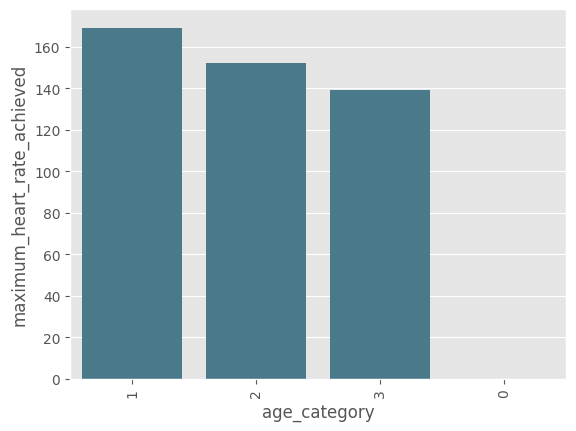

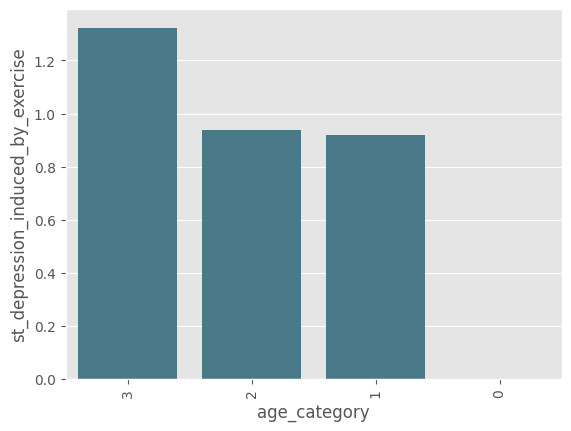

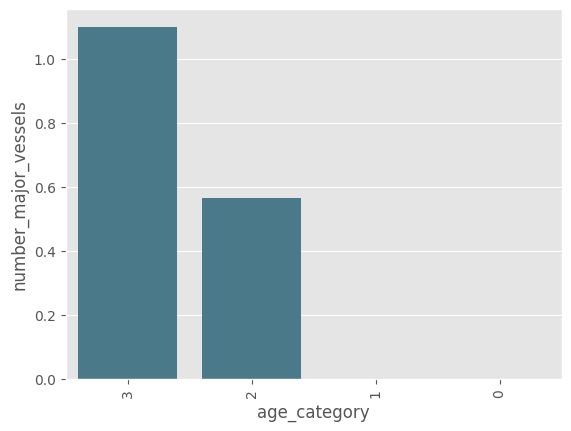

In [2349]:
numerical_features = ["resting_blood_pressure", "serum_cholesterol", "maximum_heart_rate_achieved", "st_depression_induced_by_exercise", "number_major_vessels"]
for num_feat in numerical_features:
    custom_barplot(df, 'age_category',num_feat, agg_func=np.mean)

**Age category Ordinal Encoding**

In [2350]:
encoder = OrdinalEncoder(categories=[[0, 1, 2, 3]])
df['age_category'] = encoder.fit_transform(df[['age_category']])
describe_categorical_feature(df, "age_category")

Veri tipi: float64


,age_category,count
0,2.0,201
1,3.0,79
2,1.0,17


**maximum_heart_rate_achieved kategorik değişken oluşturulması**
- Yine aynı şekilde kalp atış hızlarına göre kategorik değişken oluşturulmuştur. resting_blood_pressure değerleri birbirine çok yakın olduğundan değerlendirilmemiştir.

In [2351]:
describe_feature(df, "maximum_heart_rate_achieved")

Veri tipi: float64


,count,mean,std,min,25%,50%,75%,max
maximum_heart_rate_achieved,297.0,149.641414,22.807957,83.5,133.0,153.0,166.0,202.0


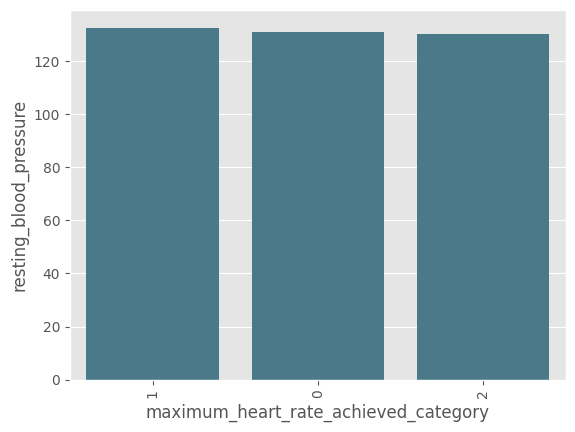

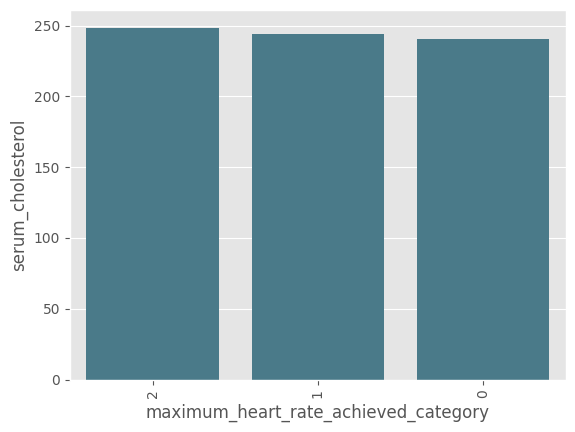

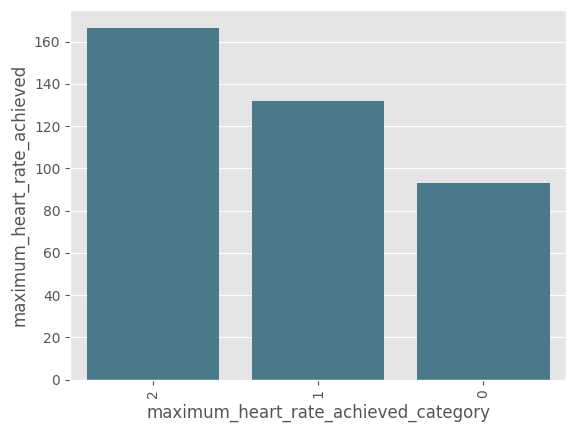

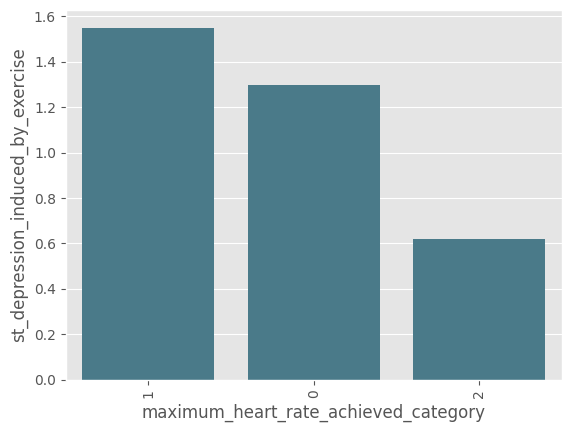

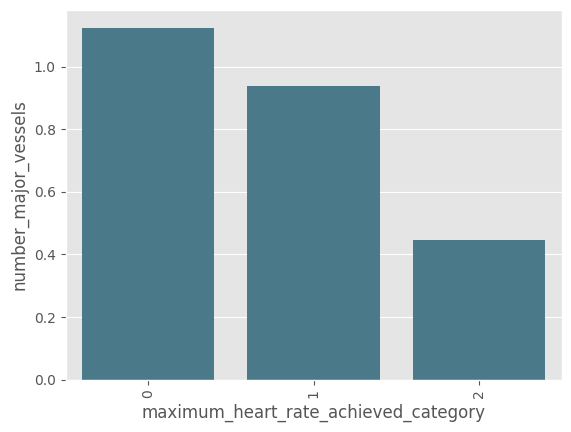

In [2352]:
mhr_bins = [-np.inf, 100, 150, np.inf]
mhr_labels = [0, 1, 2]
df['maximum_heart_rate_achieved_category'] = pd.cut(df['maximum_heart_rate_achieved'], bins=mhr_bins, labels=mhr_labels)
numerical_features = ["resting_blood_pressure", "serum_cholesterol", "maximum_heart_rate_achieved", "st_depression_induced_by_exercise", "number_major_vessels"]
for num_feat in numerical_features:
    custom_barplot(df, 'maximum_heart_rate_achieved_category',num_feat, agg_func=np.mean)

**Maximum_heart_rate_achieved_category Ordinal Encoding**

In [2353]:
encoder = OrdinalEncoder(categories=[[0, 1, 2]])
df['maximum_heart_rate_achieved_category'] = encoder.fit_transform(df[['maximum_heart_rate_achieved_category']])
describe_categorical_feature(df, "maximum_heart_rate_achieved_category")

Veri tipi: float64


,maximum_heart_rate_achieved_category,count
0,2.0,161
1,1.0,128
2,0.0,8


**serum_cholesterol kategorik değişken oluşturulması**
- Yine aynı şekilde serum_cholesterol deperlerine göre kategorik değişken oluşturulmuştur. 

In [2354]:
describe_feature(df, "serum_cholesterol")

Veri tipi: float64


,count,mean,std,min,25%,50%,75%,max
serum_cholesterol,297.0,246.260943,47.836752,126.0,211.0,243.0,276.0,373.5


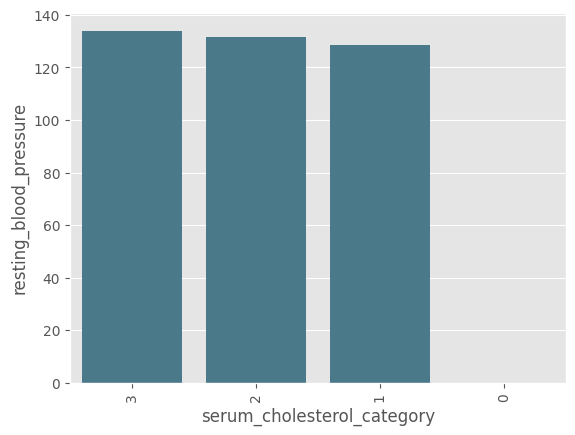

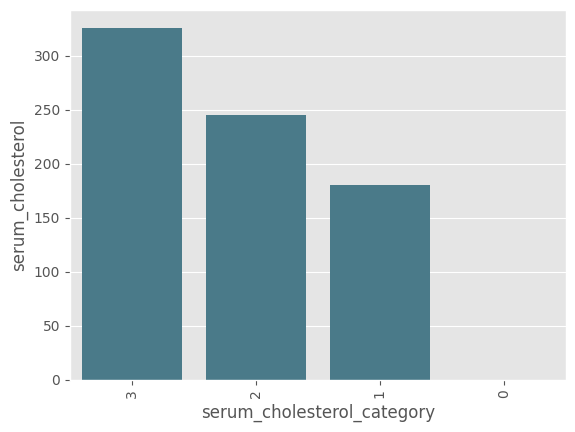

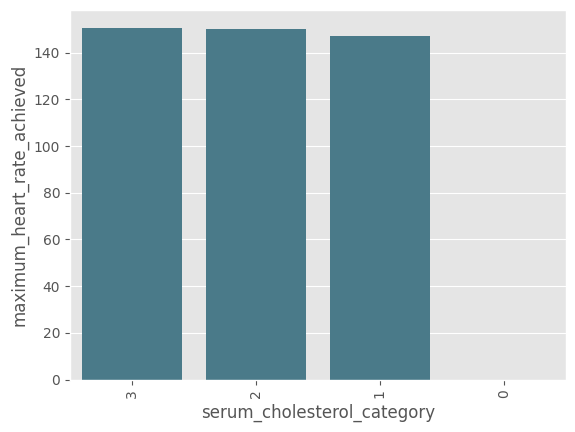

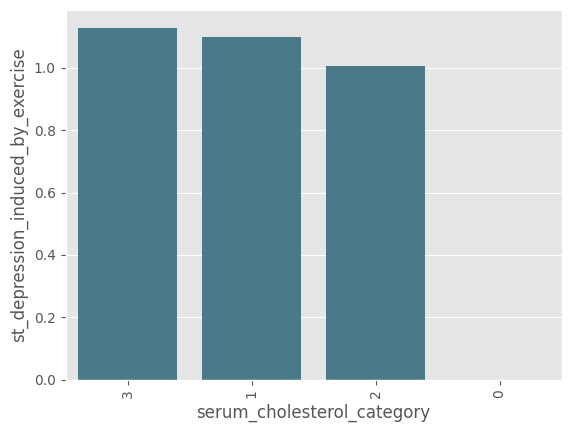

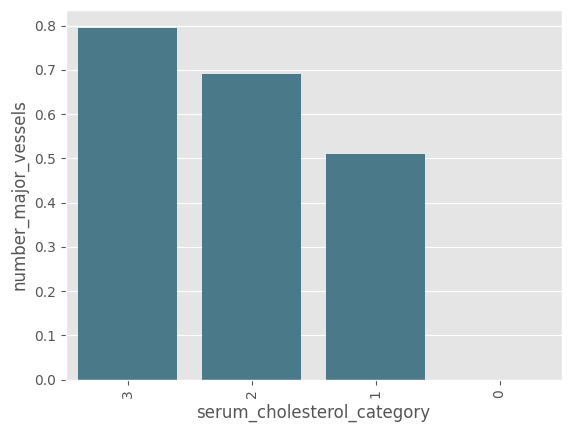

In [2355]:
mhr_bins = [-np.inf, 100, 200, 300, np.inf]
mhr_labels = [0, 1, 2, 3]
df['serum_cholesterol_category'] = pd.cut(df['serum_cholesterol'], bins=mhr_bins, labels=mhr_labels)
numerical_features = ["resting_blood_pressure", "serum_cholesterol", "maximum_heart_rate_achieved", "st_depression_induced_by_exercise", "number_major_vessels"]
for num_feat in numerical_features:
    custom_barplot(df, 'serum_cholesterol_category',num_feat, agg_func=np.mean)

**Serum_cholesterol_category Ordinal Encoding**

In [2356]:
encoder = OrdinalEncoder(categories=[[0, 1, 2, 3]])
df['serum_cholesterol_category'] = encoder.fit_transform(df[['serum_cholesterol_category']])
describe_categorical_feature(df, "serum_cholesterol_category")

Veri tipi: float64


,serum_cholesterol_category,count
0,2.0,204
1,1.0,49
2,3.0,44


**Diğer Eklenen sayısal Özellikler:**

**Tansiyon ve Kolesterol Oranı**
- Bu özellik, kişinin kan basıncı ile kolesterol düzeyinin bir oranını temsil eder. Yüksek tansiyon ve yüksek kolesterol, kalp hastalığı riskini artırabilir.

  $$
  \text{BP\_Cholesterol\_Ratio} = \frac{\text{resting\_blood\_pressure}}{\text{serum\_cholesterol}}
  $$

**Kalp Hızı ve Egzersiz İlişkisi**
- Bu özellik, maksimum kalp hızı ile egzersizle tetiklenen angina arasındaki ilişkiyi ölçer. Kalp hastalığı riskini değerlendirmek için kullanılabilir.
 
  $$
  \text{HeartRate\_Angina\_Ratio} = \frac{\text{maximum\_heart\_rate\_achieved}}{1 + \text{exercise\_induced\_angina}}
  $$
  Burada, egzersizle tetiklenen angina varlığı durumu (0 veya 1) eklenmiştir. Payda 0 olmaması için + 1 eklenmiştir.

**Egzersizle tetiklenen ST-depresyonu ve Angina İlişkisi**
- Egzersiz sırasında ST depresyonu, kalp hastalığına işaret edebilir. Bu özellik, ST depresyonu ile angina arasındaki ilişkiyi temsil eder.
  $$
  \text{ST\_Angina\_Ratio} = \frac{\text{st\_depression\_induced\_by\_exercise}}{1 + \text{exercise\_induced\_angina}}
  $$



**Toplam Damar Sayısı ve Kalp Hızı İlişkisi**
- Bu özellik, maksimum kalp hızının, floroskopi ile tespit edilmiş damar sayısı ile ilişkisini temsil eder. Bu tespit edilen damar sayısı artınca kalp hastalığı riski ertmaktadır.

  $$
  \text{HeartRate\_Vessels\_Ratio} = \frac{\text{maximum\_heart\_rate\_achieved}}{1 + \text{number\_major\_vessels}}
  $$



Elde edilen yeni özelliklerin veri setine eklenmesi:

In [2359]:
df['bp_cholesterol_ratio'] = df['resting_blood_pressure'] / df['serum_cholesterol']
df['heartrate_angina_ratio'] = df['maximum_heart_rate_achieved'] / (1 + df['exercise_induced_angina'])
df['st_angina_ratio'] = df['st_depression_induced_by_exercise'] / (1 + df['exercise_induced_angina'])
df['heartrate_vessels_ratio'] = df['maximum_heart_rate_achieved'] / (1 + df['number_major_vessels'])
df.head()

,age,sex,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,number_major_vessels,presence_of_heart_disease,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,ecg_left_ventricular_hypertrophy,ecg_normal,ecg_st_t_wave_abnormality,thal_fixed_defect,thal_normal,thal_reversable_defect,slope_downsloping,slope_flat,slope_upsloping,age_category,maximum_heart_rate_achieved_category,serum_cholesterol_category,bp_cholesterol_ratio,heartrate_angina_ratio,st_angina_ratio,heartrate_vessels_ratio
0,63.0,1,145,233.0,1,150.0,0,2.3,0.0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,3.0,1.0,2.0,0.622318,150.0,2.30,150.0
1,67.0,1,160,286.0,0,108.0,1,1.5,3.0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,3.0,1.0,2.0,0.559441,54.0,0.75,27.0
2,67.0,1,120,229.0,0,129.0,1,2.6,2.0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,3.0,1.0,2.0,0.524017,64.5,1.30,43.0
3,37.0,1,130,250.0,0,187.0,0,3.5,0.0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1.0,2.0,2.0,0.520000,187.0,3.50,187.0
4,41.0,0,130,204.0,0,172.0,0,1.4,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,2.0,2.0,2.0,0.637255,172.0,1.40,172.0


# Feature Selection

- Bu bölümde özellik seçimi yapılır özellik çıkarımı bölümünde çıkarılan özelliklere karşı bir filtre görevi görmektedir.

**Korelasyon Analizi**

- Hedef değişkenimiz presence_of_heart_disease dir. Bu değişken ile diğer sayısal değişkenlerin arasında bir korelasyon olup olmadığı analiz edilmiştir. 

**Pairplot**

- Bütün özelliklerin görselleştirilmesi uzun sürdüğü ve okunabilir olmadığı için sadece sayısal değişkenler görselleştirilmiştir.
- age ile maximum_heart_rate_achieved arasında güçlü negatif korelasyon göze çarpmaktadır, 
- yine age ile serum kolestrol arasında güçlü olabilecek bir ilişki gözlemlenmektedir.


<Figure size 2500x1500 with 0 Axes>

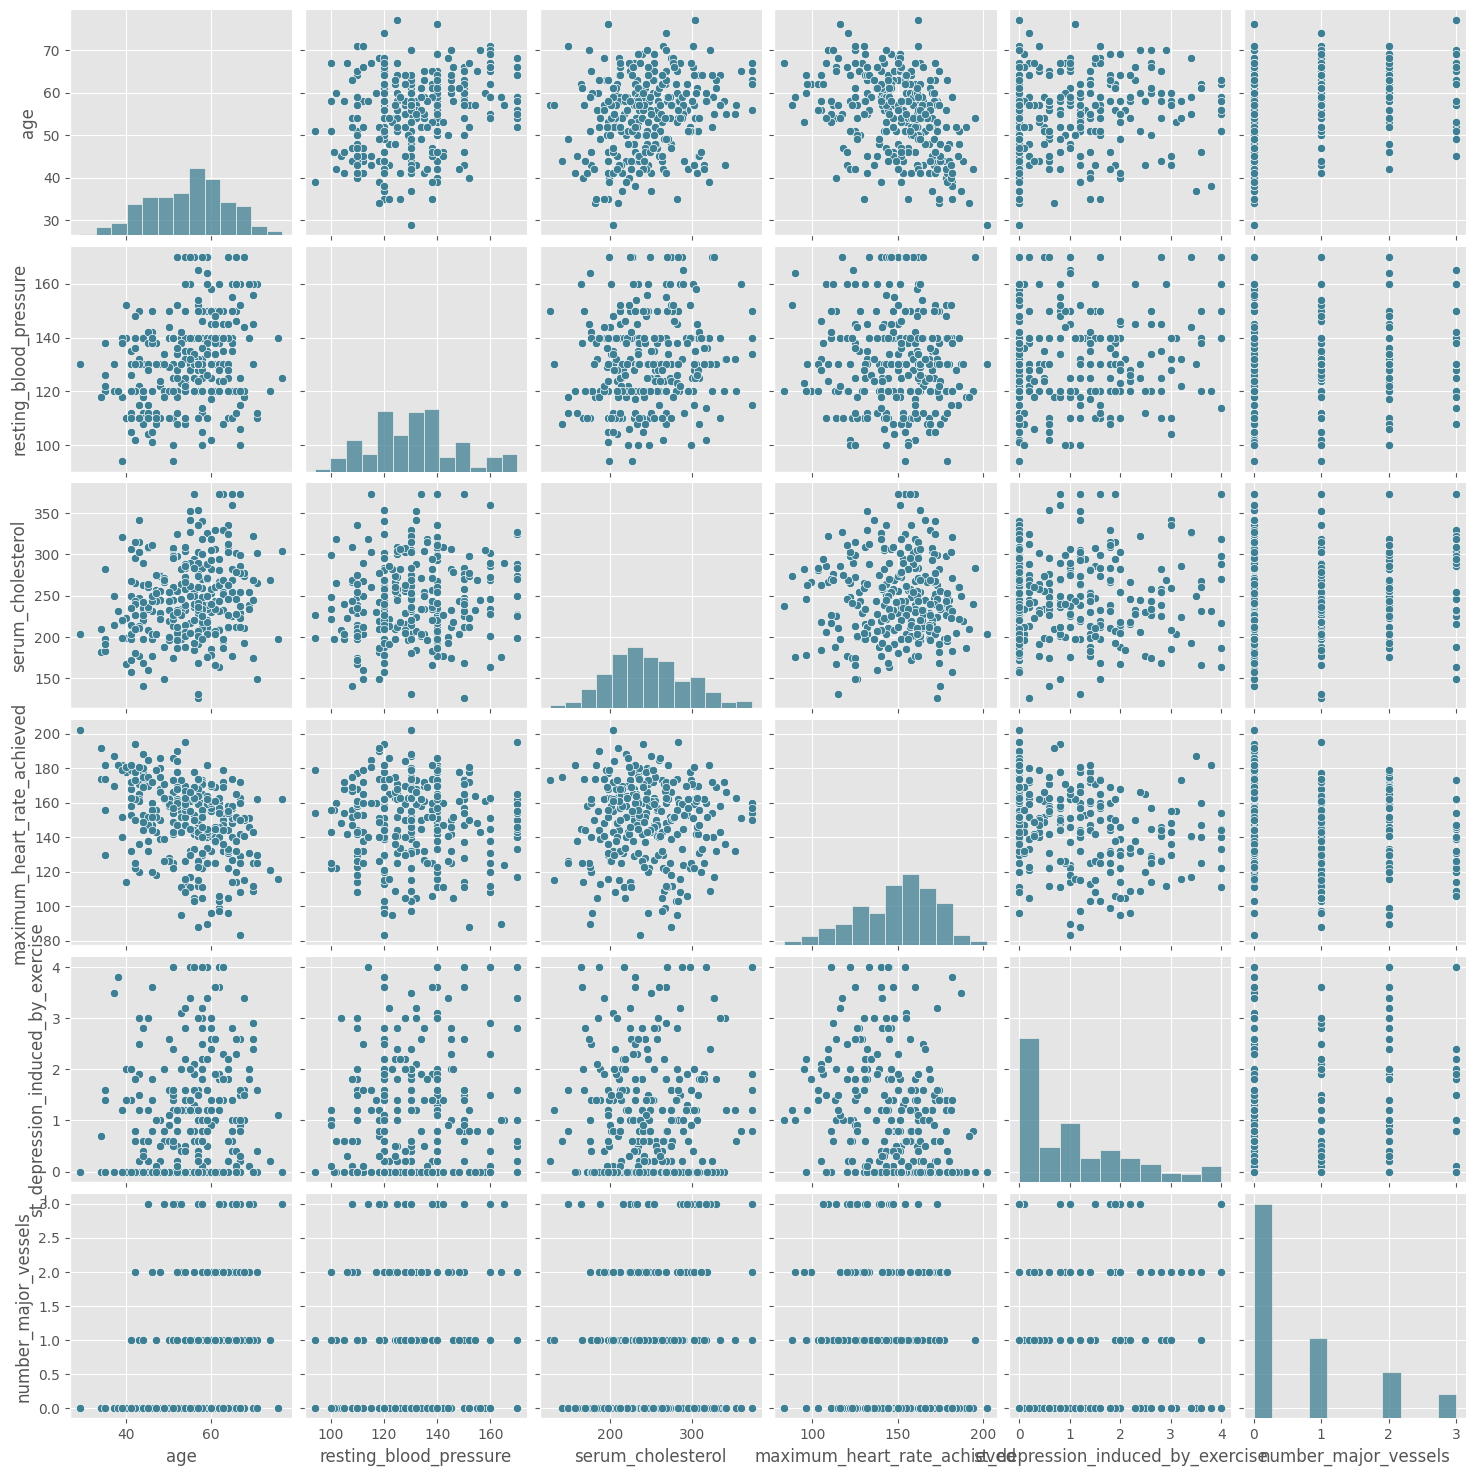

In [2360]:
plt.figure(figsize=(25, 15))
sns.pairplot(data=df[numeric_features])
plt.show()

**Heatmap**

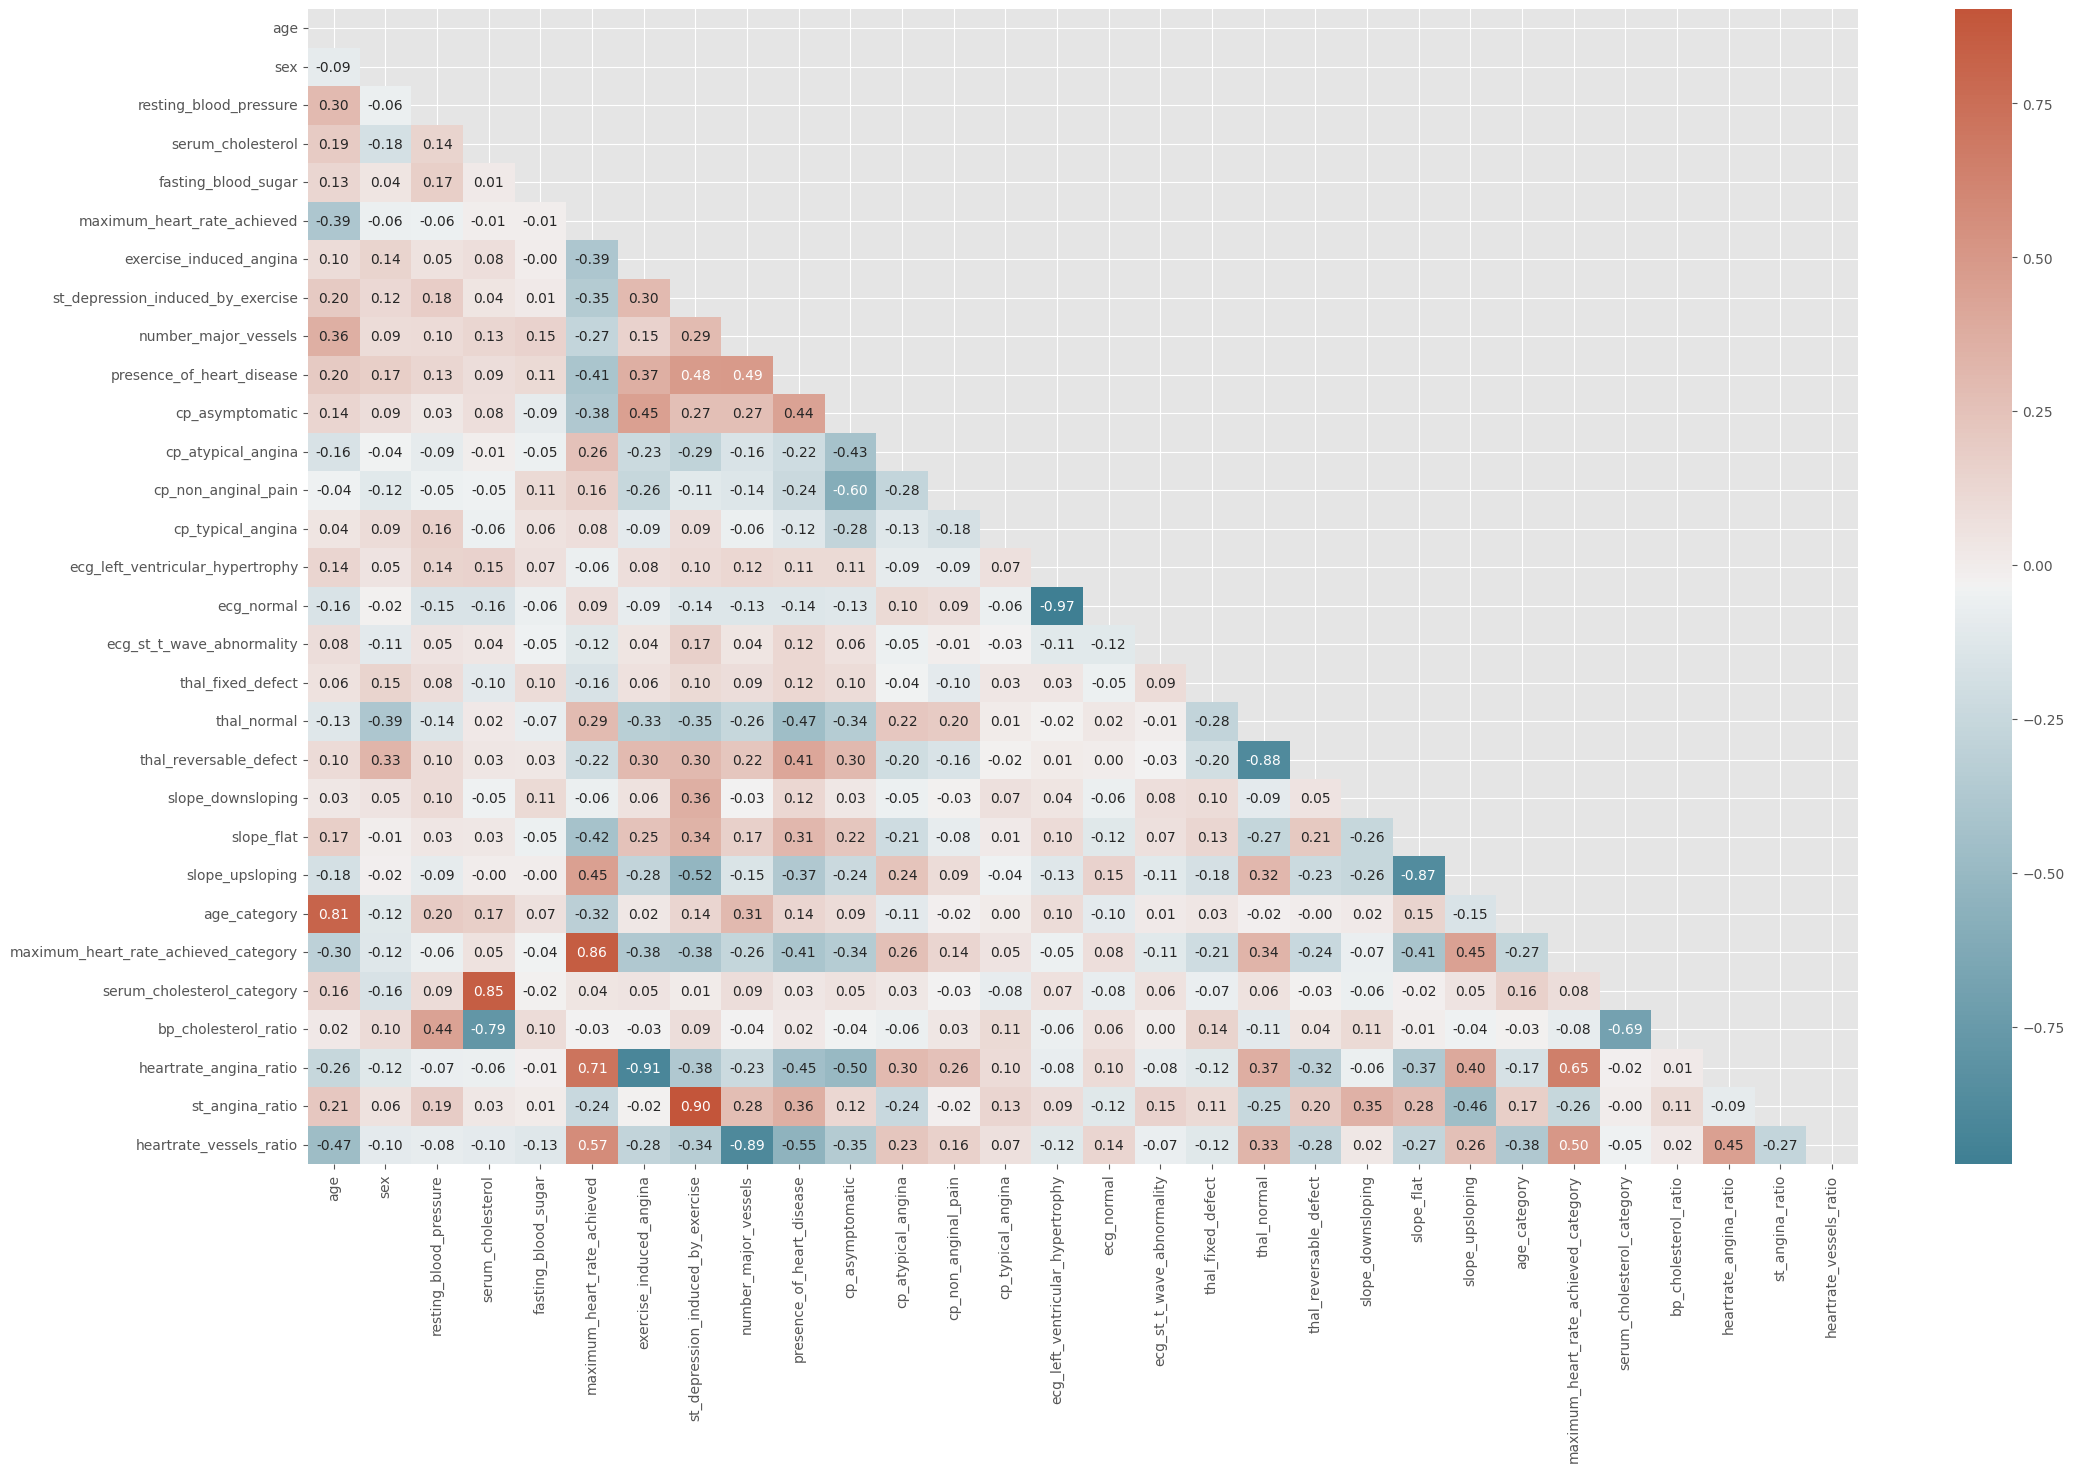

In [2361]:
plt.figure(figsize=(25, 15))
num_variables = df.select_dtypes(include=["float64","int64","int32"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Heatmap incelemesi ve birbiri arasında korelasyonlu değişkenlerin tespiti**

- Heatmapi incelediğimizde korelasyonlar renkler ile açıkça görülmektedir. Kırmızılar pozitif maviler negatif korelasyonları temsil etmektedir.

Değişkenler arasında 0.70 den fazla korelasyonu olanlar multicollinearity problemi oluşturulabilir. Bu nedende korelasyonlu değişkenlerden birinin çıkarılması genelde tercih edilebilir.
Yüksek korelasyonlu değişkenler aynı bilgiyi ifade ettiklerinden aralarındaki küçük farklar makine öğrenimi modelini yanıltabilir. Bu nedenle bu değişkenlerin çıkarılması model performansını artırabilir.
Yeni eklenen özellikler yüksek korelasyona göstermektedir. Yinede etkilerini görmek için eşik 0.85 olarak belirlenmiştir.

Bu değişkenlerden bazıları:
- ecg_normal - ecg_left_ventricular_hypertropy: -0.97 lik çok yüksek negatif korelasyon vardır. 
- thal_mormal - thal_reversible_defect: -0.88 lik çok yüksek negatif korelasyon vardır. 
- slope_flat - slope_upsloping: -0.87 lik çok yüksek negatif korelasyon vardır.

**Bu işlem için bir fonksiyon yazılmıştır. Eşik değer üzerindeki korelasyonlu özelliklerden birinin çıkarılması hedeflenmiştir.**

In [2362]:
def correlation_analysis(df, threshold=0.85):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    df.drop(columns=to_drop, axis=1, inplace=True)
    print(f"Veri setinden çıkarılan özellikler:{to_drop}")
    return df

In [2363]:
print(f"Korelasyonlu özellikler çıkarılmadan önceki özellik sayısı: {len(df.columns)}")
df = correlation_analysis(df)
print(f"Korelasyonlu özellikler çıkarılmadan sonraki özellik sayısı: {len(df.columns)}")

Korelasyonlu özellikler çıkarılmadan önceki özellik sayısı: 30
Veri setinden çıkarılan özellikler:['ecg_normal', 'thal_reversable_defect', 'slope_upsloping', 'maximum_heart_rate_achieved_category', 'heartrate_angina_ratio', 'st_angina_ratio', 'heartrate_vessels_ratio']
Korelasyonlu özellikler çıkarılmadan sonraki özellik sayısı: 23


**Verisetine korelasyon analizinden geçen age_category, serum_cholesterol_category ve bp_cholesterol_ratio yeni özellikler olarak eklenmiştir.**

**Hedef özellik (presence_of_heart_disease) ile diğer özelliklerin arasındaki korelasyonların tespiti**
- Burada target değişken presence_of_heart_disease ile sayısal değişkenlerin korelasyonuna bakılmıştır. Eşik değer 0.05 korelasyonlu olarak belirlenmiş ve görselleştirilmiştir. 
- İlk önce birbiri ile korelasyonlu değişkenler kaldırılıp tam olarak hedef değişken ile korelasyonlu değişkenlerin kaç adet olduğu tespit edilmiştir. 
- Target değişken ile bağımsız değişkenler arasında 0.05 korelasyondan yüksek 18 özellik tespit edilmiştir.

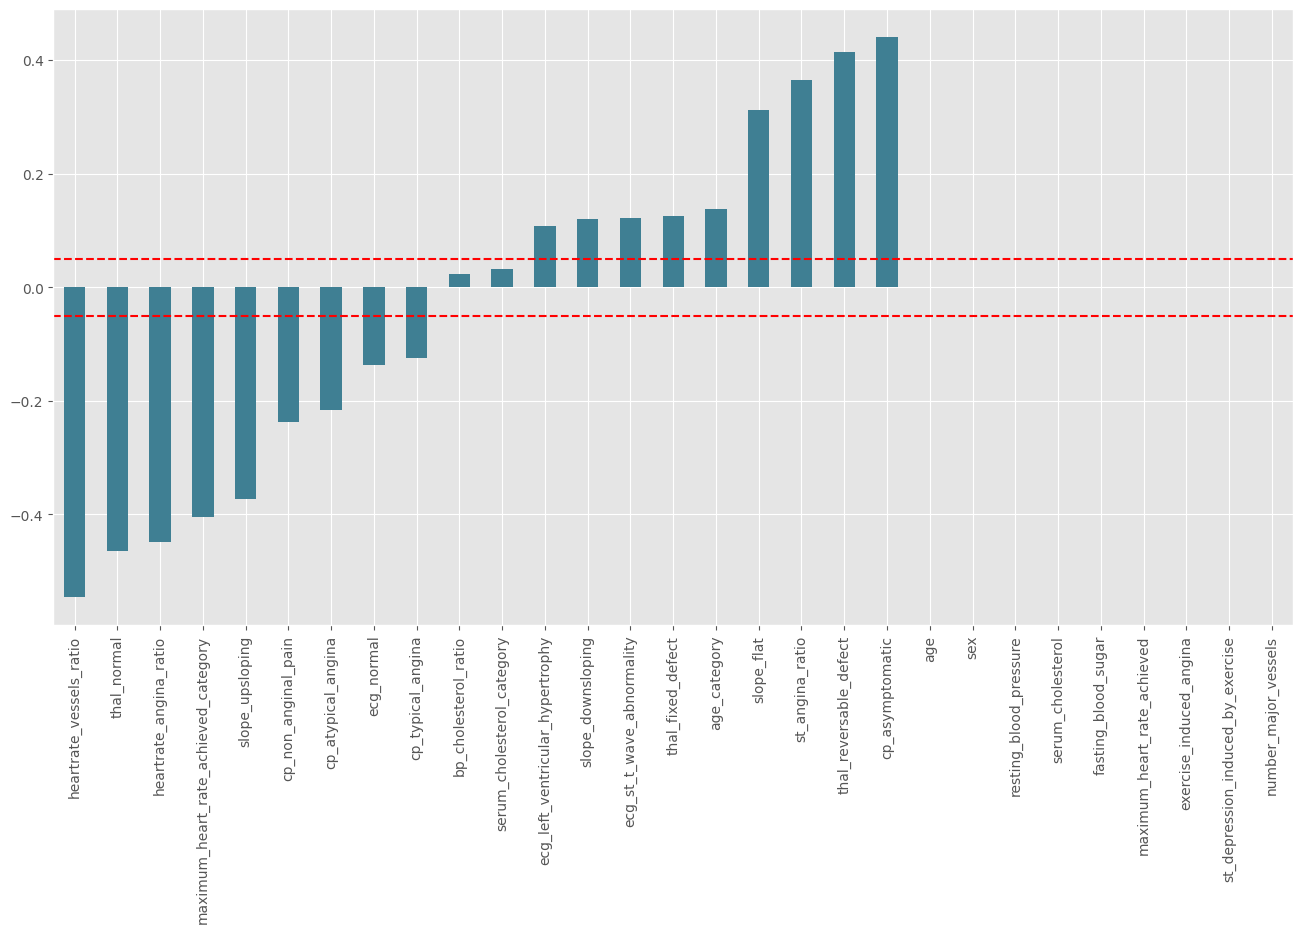

In [2365]:
plt.figure(figsize=(16, 8))
tri_df["presence_of_heart_disease"].drop("presence_of_heart_disease").sort_values().plot(kind="bar")
plt.axhline(0.05, color ="red",linestyle ='--')
plt.axhline(-0.05, color='red',linestyle='--')
plt.show()

In [2366]:
cor_target = abs(tri_df["presence_of_heart_disease"])
cor_target.drop("presence_of_heart_disease",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.05]
print("Toplam özellik sayısı:",len(df.select_dtypes(include=["float64","int64","int32"]).columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam özellik sayısı: 23
Korelasyonlu özellik sayısı: 18


# Model Oluşturma ve Değerlendirme

### Bu bölüm altında projede istenen scaling, normalization, sampling işlemleri ilgili yerlerde yapılacaktır.

**Kullanılacak Modellerin Seçimi**

- presence_of_heart_disease yani kişinin kalp hastası olup olmadığının tahmin edilmesi, makine öğreniminde binary sınıflandırma problemidir. 
  
- Occam's razor yani basit modelden karmaşık modele gitme prensibinden yola çıkılarak ilk olarak Lojistik Regresyon modeli kullanılmıştır. Veri setinde güçlü doğrusal korelasyonlar bulunduğundan iyi performans gösterebilir. Logistic regresyonu ayrıca tek neronlu basit bir sinir ağı olarakda düşünebiliriz. Loss(kayıp) fonksiyonu olarak katsayıların güncellenmesinde binary crossentropy fonksiyonu kullanılır. 
  
- İkinci model olarak ağaç tabanlı bir model kullanılması tercih edilmiştir. Ağaç tabanlı modellerden de boosting(örn: xgboost), bagging(bootstrap aggregation) modelleri(örn: random forest) arasında seçim yapılması gerektiğinde RandonForestClassifier modeli tercih edilmiştir. Bunun nedenide boosting algoritmaları özelliklede xgboost yüksek boyutlu veri setlerinde daha iyi performans gösterirler. Projemizdeki veri seti çok küçük olduğundan overfitting(aşırı uyum) olma ihtimali dahada artabileceğinden karşılaştırma modeli olarak Random Forests Classifier'ı seçilmiştir. 
  
- Ağaç tabanlı model seçilmesinin bir diğer nedenide sınıf dengesizliği sorununu ele alabilir ve dengesiz veri setlerinde iyi performans gösterebilir. Ayrıca, tek bir ağaç modeli yerine, birçok bağımsız zayıf ağacın ortak kararıyla sonuç üreten ve kalabalık bilgeliği prensibine dayanan sıklıkla kullanılan bir model olan Random Forest Classifier kullanılmıştır. Ayrıca ağaç tabanlı modeller ölçeklemeye karşıda dirençlidir. Veri seti ölçeklenmedende kullanılabilir.
  
-  Her iki modelin de sınıf dengesizliklerini class_weights parametresi ile ele alması ve düşük yoğunluklu sınıflara önem vererek ele almaktadır. 
  
---

**Değerlendirme Metriklerinin Seçimi**

İlk metrik seçimi için önemli olabilecek 2 metrik için değerlendirme yapılmıştır. 

**Precision (Kesinlik):**

- **Tanım:** Doğru pozitif tahminlerin, tüm pozitif tahminlere (doğru pozitif + yanlış pozitif) oranıdır.
- **Formül:**
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
- **Anlamı:** Modelin pozitif sınıfa (kalp hastalığı) ait olarak sınıflandırdığı hastaların ne kadarının gerçekten kalp hastalığına sahip olduğunu gösterir.
- Eğer yanlış pozitifler (kalp hastası olarak yanlış sınıflandırılan sağlıklı bireyler) ciddi sonuçlara yol açıyorsa, precision daha önemli olabilir. Örneğin, hastalara gereksiz tedavi veya endişe vermemek için, yanlış pozitiflerin sayısını azaltmak önemlidir.

**Recall (Duyarlılık):**

- **Tanım:** Gerçek pozitiflerin (kalp hastalığı olanlar) tüm pozitif durumlara (gerçek pozitif + yanlış negatif) oranıdır.
- **Formül:**
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
- **Anlamı:** Gerçek kalp hastalığı olan hastaların ne kadarının doğru bir şekilde tespit edildiğini gösterir.
- Eğer yanlış negatifler (kalp hastalığı olan bireylerin sağlıklı olarak sınıflandırılması) daha büyük bir risk taşıyorsa, recall daha önemli olabilir. Örneğin, kalp hastalığı olan bir bireyin hastalığının tespit edilmemesi, hayati tehlikelere yol açabilir.


- Kalp hastalığı olan birinin sağlıklı olarak sınıflandırılmaması gerektiği düşünüldüğünden ilk değerlendirme metriği olarak **RECALL** seçilmiştir.


İkinci metrik olarak **ROC AUC score** seçilmiştir. ROC AUC score, modelin tüm sınıfları (hem pozitif hem de negatif) doğru şekilde ayırt etme yeteneğini değerlendirir. Bu, yanlış pozitifler ve yanlış negatifler (duyarlılık ve özgüllük -(sensitivity and specificity)) arasında bir denge kurmaya odaklanır.

---

**Model Değerlendirme Fonksiyonunu Tanımlama**

Tüm model eğitim ve değerlendirme sürecini kolay ve hatasız hale getirmek için bir fonksiyon içinde gerçekleştirilmiştir. Bu fonksiyon modeli, bölünmüş verileri, cross-validation fonksiyonunu ve score fonksiyonunu parametre olarak alır ve eğitimli modeli, eğitim ve doğrulama puanlarını içeren dataframe'i, nihai test puanını ve test seti üzerindeki tahminleri döner. Eğer plot parametresi True olarak belirtilirse, eğitim ve doğrulama sonuçlarını çizer. Eğitim verileri üzerinde cross-validation uygulamak, model değerlendirme aşamasında sıkça tercih edilen bir yöntemdir. Bu şekilde, modelin eğitim, doğrulama ve test seti üzerindeki sonuçlarını karşılaştırarak aşırı uyum (overfitting) ve yetersiz uyum (underfitting) durumlarını daha kolay gözlemlenebilir ve hiperparametreler bu sonuçlara göre ayarlayabilir. Ayrıca, problem sınıflandırma ise fonksiyon, confusion matrix'i de yazdırır. sklearn'deki karmaşıklık matrisi, modelin doğru negatif, yanlış pozitif tahminlerini birinci satırda ve yanlış negatif, doğru pozitif tahminlerini ikinci satırda gösterir.

![Local Image](./confusion.jpg)

**Model Tracking(Mlflow)**
- Yapılan hiperparametre ayarlamalarının, modellerin, sürekli izlenmesi amacı ile Mlflow kütüphanesi kullanılmıştır. 
- Mlflow kütüphanesi her yapılan işlemi kayıt altına aldığından çalışmalarda çok kolaylık sağlamaktadır.
- Model tracking server yada localde kayıt yapma özelliği vardır. İşlemlerin AWS S3 gibi servislere kaydı vakit alacağından kayıt yeri olarak local seçilmiştir.

In [2367]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,score_func, cv_type, plot=True):
 
    # score listelerinin tanımanması
    train_scores = []
    validation_scores = []
    score_per_fold = []
    fold = 1

    # overfitting underfitting tespiti için cross validation aşaması
    for train_index, test_index in cv_type.split(X_train,y_train):
        X_train_cv, X_validation_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_validation_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # cross validation eğitim seti model fit 
        model.fit(X_train_cv, y_train_cv)
        y_pred_train = model.predict(X_train_cv)
        y_pred_validation = model.predict(X_validation_cv)
        
        # eğitim scorlarının hesaplanması
        train_score = score_func(y_train_cv, y_pred_train)
        
        # validation scorelarıın hesaplanması
        validation_score = score_func(y_validation_cv, y_pred_validation)

        # scoreların listelere eklenmesi
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        # socreların her fold için yazdırılması
        print(f'Fold {fold} eğitim_{score_func.__name__}: {train_score:.2f}')
        print(f'Fold {fold} validasyon_{score_func.__name__}: {validation_score:.2f}')

        fold += 1
        # fold sayısının listeye eklenmesi
        score_per_fold.append(fold)

    print("Cross validation aşaması tamamlandı! Model eğitimine başlandı...")

    # Cross validasyon aşaması tamamlandıktan sonra modelin tüm veri seti üzerinde tekrar eğitilmesi
    model.fit(X_train, y_train)
    print("*******************************************")
    print("Model eğitimi tamamlandı!")
    print("*******************************************")

    # test seti üzerinde tahmin yapılması ve eğer skor fonksiyonunun adı `roc_auc_score` ise, 1 sınıfına ait tahmin edilen olasılıkların alınması.
    if score_func.__name__ == "roc_auc_score":
        y_pred_test = model.predict_proba(X_test)[:,1]
    else:
        y_pred_test = model.predict(X_test)
    
    # En son test seti üzerinde score hesaplanması
    final_test_score = score_func(y_test, y_pred_test)

    # scoreların sözlüğe kaydedilmesi
    scores_dict = {
    "fold": range(1, len(score_per_fold) + 1),
    f"eğitim_{score_func.__name__}": train_scores,
    f"validasyon_{score_func.__name__}": validation_scores
    }
    
    # plot için df oluşturulması
    scores_df = pd.DataFrame(scores_dict)
    
    # validasyon scorunun eğitim scoruna göre farkının % değeri.
    percentage_difference_train_valid = ((np.mean(validation_scores) - np.mean(train_scores)) / np.mean(train_scores)) * 100

    # final scoreun eğitim scoruna göre farkının % değeri.
    percentage_difference_train_test = ((final_test_score - np.mean(train_scores)) / np.mean(train_scores)) * 100

    print(f"Ortalama eğitim_{score_func.__name__} sonuç: {np.mean(train_scores):.2f}")
    print(f'Ortalama validasyon_{score_func.__name__} sonuç: {np.mean(validation_scores):.2f}')
    print(f'Son test_{score_func.__name__} sonuç: {final_test_score:.2f}')
    print(f'Validasyon scorunun eğitim scoruna göre farkının % değeri:%{percentage_difference_train_valid:.2f}')
    print(f'Final scoreun eğitim scoruna göre farkının % değeri:%{percentage_difference_train_test:.2f}')
    # it prints confusion matrix if the problem is classification
    if score_func.__name__ in ["precision_score","recall_score","f1_score"]:
        cf_matrix = confusion_matrix(y_test, y_pred_test)
        print(f"Son test seti için oluşturulan confusion matrix:\n {cf_matrix}")

    print("*******************************************")

    if plot:
        sns.lineplot(data=scores_df, x="fold", y=f"eğitim_{score_func.__name__}", marker="o", label=f"eğitim_{score_func.__name__}")
        sns.lineplot(data=scores_df, x="fold", y=f"validasyon_{score_func.__name__}", marker="v", label=f"validasyon_{score_func.__name__}")
        plt.xlabel("Fold")
        plt.ylabel(f"{score_func.__name__}")
        plt.title(f"Her folddaki {score_func.__name__}")
        plt.legend()
        plt.show()

    return  model, final_test_score, scores_df, y_pred_test

**ROC Eğrisi Fonksiyonunu Tanımlama**

ROC eğrisi, bir ikili sınıflandırma modelinin performansını farklı eşik değerlerinde grafiksel olarak gösterir. Bu eğri, gerçek pozitif oranını (TPR) yanlış pozitif oranına (FPR) karşı çizer. TPR, modelin gerçek pozitif vakaları ne kadar doğru tespit ettiğini ölçerken, FPR, modelin negatif vakaları yanlış bir şekilde pozitif olarak sınıflandırma oranını ölçer. ROC eğrisi, sınıflandırıcının karar eşiği değiştikçe TPR ve FPR arasındaki dengeyi görselleştirir. Eğri Altındaki Alan (AUC), eğrinin altındaki alanı temsil eder ve modelin genel performansını ölçmek için kullanılır. Bu nedenle, ROC eğrisi ve AUC, ikili sınıflandırma modellerinin performansını değerlendirmek ve karşılaştırmak için önemli araçlardır.

In [2368]:
def plot_roc_curve(y_true, y_pred_prob):

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

    # Compute Area Under Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="teal", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="lightsteelblue", lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

In [2369]:
df.head()

,age,sex,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,number_major_vessels,presence_of_heart_disease,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,ecg_left_ventricular_hypertrophy,ecg_st_t_wave_abnormality,thal_fixed_defect,thal_normal,slope_downsloping,slope_flat,age_category,serum_cholesterol_category,bp_cholesterol_ratio
0,63.0,1,145,233.0,1,150.0,0,2.3,0.0,0,0,0,0,1,1,0,1,0,1,0,3.0,2.0,0.622318
1,67.0,1,160,286.0,0,108.0,1,1.5,3.0,1,1,0,0,0,1,0,0,1,0,1,3.0,2.0,0.559441
2,67.0,1,120,229.0,0,129.0,1,2.6,2.0,0,1,0,0,0,1,0,0,0,0,1,3.0,2.0,0.524017
3,37.0,1,130,250.0,0,187.0,0,3.5,0.0,0,0,0,1,0,0,0,0,1,1,0,1.0,2.0,0.520000
4,41.0,0,130,204.0,0,172.0,0,1.4,0.0,0,0,1,0,0,1,0,0,1,0,0,2.0,2.0,0.637255


**Veri setinin eğitim ve test olarak bölünmesi ve SMOTE oversampling uygulanması**

**Veri setinde presence_of_heart_disease hedef değişkeninde sınıf dengesizliği bulunmaktadır.**

- Sınıf dengesizliğini ele almak için 4 yöntem uygulanmıştır.
  
- 1. Bölme işleminde stratify parametresi kullanılmıştır. train_test_split fonksiyonu bölme yaparken bunu dikkate alır.
  
- 2. Kullanılan modellerde class_weight parametresi balanced yapılmıştır.
  
- 3. Sınıf dengesizliğinde sıklıkla kullanılan **SMOTE** oversampling metodu kullanılmıştır.
  
- 4. Cross validation fonksiyonu olarak StratifiedKfold kullanılmıştır.

In [2370]:
describe_categorical_feature(df, "presence_of_heart_disease")

Veri tipi: int64


,presence_of_heart_disease,count
0,0,214
1,1,83


# Sampling

**SMOTE (Synthetic Minority Over-sampling Technique)**

SMOTE, dengesiz veri setlerinde azınlık sınıfının örneklerini artırmak için kullanılan bir over-sampling yöntemidir. Bu teknik, mevcut azınlık sınıfı örnekleri arasındaki farkları kullanarak sentetik örnekler oluşturur ve böylece sınıflar arasındaki dengesizliği azaltır.

**Çalışma şekli:**
1. **K En Yakın Komşu**: Her bir azınlık sınıfı örneği için k en yakın komşu belirlenir.
2. **Yeni Örnekler Oluşturma**: Rastgele bir komşu seçilir ve bu komşu ile mevcut örnek arasındaki vektör boyunca yeni bir örnek oluşturulur.
3. **Oversampling**: Bu adımlar tekrarlanarak veri setine yeni sentetik azınlık sınıfı örnekleri eklenir.

**Avantajları:**
- **Dengesiz Verilerin Dengelenmesi**: Azınlık sınıfı örneklerini artırarak veri setindeki sınıf dengesizliğini azaltır.
- **Overfitting'i Azaltma**: Yeni örnekler oluştururken sadece mevcut örnekleri tekrar etmek yerine yeni sentetik örnekler üreterek overfitting riskini azaltır.
  
**SMOTE, eğitim setindeki azınlık sınıfı örneklerini artırarak modelin bu sınıfı daha iyi öğrenmesini sağlar. Ancak, test seti modelin performansını değerlendirmek için kullanılır ve bu set üzerinde herhangi bir müdahale yapılmamalıdır. Test seti, modelin eğitim süreci dışında kalmalı ve gerçek dünya performansını yansıtmalıdır.**

---

**Özellik seçim ve verilerin bölünmesi**
- Verilerin bölünmesinde test size seçimi önemli ayarlamalardan bir tanesidir.
- Test boyutu seçiminde %10, %12, %15, %20 ve %25 değerleri kullanılmış model değerlendirme fonksiyonunda uygulanmıştır. En eğitim, validasyon ve final scorelara göre en uygun test boyutu %12 seçilmiştir(eğitim recall = 0.88, validation recall=0.89, test recall=0.90- scaled).

In [2371]:
mlflow.set_tracking_uri("file:///C:/Users/iskorpittt/Desktop/MY_DATA_SCIENCE/PROJECTS/kodlasam_hearth_disease_project/mlruns")
mlflow.set_experiment("heart_disease_classification")

<Experiment: artifact_location='file:///C:/Users/iskorpittt/Desktop/MY_DATA_SCIENCE/PROJECTS/kodlasam_hearth_disease_project/mlruns/367194866272300660', creation_time=1721977320429, experiment_id='367194866272300660', last_update_time=1721977320429, lifecycle_stage='active', name='heart_disease_classification', tags={}>

In [2372]:
target = "presence_of_heart_disease"
columns_that_will_not_used = ["presence_of_heart_disease"]
features = [col for col in df.columns if col not in columns_that_will_not_used]
X = df[features]
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, stratify=y, random_state=42)

In [2373]:
print(X_train.shape)
print(y_train.shape)
y_train.value_counts(normalize=True) * 100

(261, 22)
(261,)


presence_of_heart_disease
0    72.030651
1    27.969349
Name: proportion, dtype: float64

In [2374]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

- SMOTE işlemi sonucunda X_train satır sayısı 261, den 376'ya çıkmış sentetik datalar üretilmiştir.
- SMOTE öncesi %72 0, %28 1 değeri varken, işlem uygulandıktan sonra %50, %50 olacak hale gelmiştir.
- SMOTE işlemi sadece eğitim setine uygulanmıştır.

In [2375]:
print(X_train_smote.shape)
print(X_test.shape)
print(y_train_smote.shape)
print(y_test.shape)
y_train_smote.value_counts(normalize=True) * 100

(376, 22)
(36, 22)
(376,)
(36,)


presence_of_heart_disease
0    50.0
1    50.0
Name: proportion, dtype: float64

**Modelleme**

**Lojistik Regresyon Modeli**

Yüksek oranda sağa çarpıtılmış veriler, modelin daha iyi performans göstermesi için ölçeklenmelidir. Bunun için, pipeline içinde `StandardScaler` kullanılmıştır.

Veri sayısı çok büyük olmadığından, hiperparametre ayarlamaları için en doğru sonucu almak amacıyla GridSearchCV yöntemi kullanılmıştır. Bu süreç sonucunda, düzenleme C değeri 0.005 olarak ve ceza değeri l2 (ridge) olarak belirlenmiştir. Hedef değişkenimizde bir sınıf dengesizliği olduğu için, daha az etkili sınıfı daha fazla dikkate almak adına `class_weight="balanced"` seçeneği tercih edilmiştir.

- **C**: Lojistik regresyondaki regularizasyon parametresidir. Daha küçük değerler daha güçlü regularizasyonu ifade eder ve model üzerindeki bireysel veri noktalarının etkisini azaltır.
- **Penalty**: Lojistik regresyonda kullanılan regularizasyon cezasının türüdür. "l2" Ridge regularizasyonu ifade eder, bu  katsayıların karelerinin büyüklüğünü cezalandırarak daha küçük katsayı değerlerini teşvik eder.

Sınıf dengesizliğini ele almak için çapraz doğrulama için StratifiedKFold seçilmiştir.

**Logistic regression hyperparameter tuning**

- Hyperparameter tuning için veri sayısı az olduğundan, brute force yöntemi ile bütün kombinasyonları deneyen Gridsearch kullanılmıştır. 
- Verisayısı ve parametre fazla olduğunda, bu yöntem kullanılamaz hale gelebilir. İşlem süreleri çok uzar. Böyle durumlarda Random search yada bayesian algoritmaları kullanılabilir.

In [2376]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
scoring = make_scorer(recall_score) 
lr_cv = LogisticRegression()

lr_pipeline_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", lr_cv)
])

params_lr = {
    "classifier__penalty": ["l1", "l2","elasticnet"],
    "classifier__C": [0.0001, 0.001, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 200],
    "classifier__class_weight": ["balanced"] 
} 

with mlflow.start_run(run_name="GridSearchCV Logistic Regression"):

    grid_rf = GridSearchCV(estimator=lr_pipeline_cv,param_grid=params_lr,cv=skf,scoring=scoring,verbose=1,n_jobs=1)
    grid_rf.fit(X,y)
    best_hyperparams_lr = grid_rf.best_params_
    best_score_lr = grid_rf.best_score_
    print("Logistic Regression için en iyi hiperparametreler:", best_hyperparams_lr)
    print("Logistic Regression için en iyi score(recall):", best_score_lr)
    
    # Hyperparametreleri ve en iyi skorların mlflow'a kaydedilmesi
    mlflow.log_params(best_hyperparams_lr)
    mlflow.log_metric("lr_best_recall_score", best_score_lr)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Logistic Regression için en iyi hiperparametreler: {'classifier__C': 0.005, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
Logistic Regression için en iyi score(recall): 0.8680555555555556


# Scaling

**Verisetinde denenen ölçekleme yöntemleri**

#### MinMaxScaler
**MinMaxScaler**, veriyi belirli bir aralıkta (genellikle 0 ile 1 arasında) ölçekler. Bu ölçekleme, verinin minimum ve maksimum değerleri kullanılarak yapılır.

- **Formül:**
  $$
  z = \frac{x - x_{min}}{x_{max} - x_{min}}
  $$

#### StandardScaler
**StandardScaler**, veriyi ortalama 0 ve standart sapma 1 olacak şekilde ölçekler. Bu, verinin dağılımını merkezler ve ölçekler.

- **Formül:**
  $$
  z = \frac{x - \mu}{\sigma}
  $$

#### RobustScaler
**RobustScaler**, veriyi medyan ve yüzde değer aralıkları kullanarak ölçekler. Bu ölçekleme yöntemi, aykırı değerlere karşı daha dayanıklıdır.

- **Formül:**
  $$
  z = \frac{x - \text{medyan}}{IQR}
  $$


- Sayısal verilerde aykırı değer analizi yapılmış ve aykırı değerler baskılanmıştır. Fakat yinede sağa ve sola çarpık özellikler bulunmaktadır.Linear modellerde bunlar bozucu etki yapabilir ve model performansını olumsuz etkiler.
- Bu nedenle verileri uygun bir ölçeğe getirmek model performansını artırabilir.
- Aykırı değer işlemleri yaptığımızdan ve çok aşırı çarpıklıklar olmadığından `StandarScaler` yöntemi kullanılabilir. 
- Yinede 3 yöntem denenmiş en uygun olarak `StandarScaler` en iyi scoreları vermiştir.
- Logistic regression modelinde `StandarScaler` uygulandıktan sonra Recall test scoru 0.80 den, 0.90 ' a yükselmiştir. 
  

---

**Scaling olmadan model eğitim ve değerlendirmesi**

- Ortalama eğitim_recall_score sonuç: 0.78
- Ortalama validasyon_recall_score sonuç: 0.79
- Son test_recall_score sonuç: 0.80
- Validasyon scorunun eğitim scoruna göre farkının % değeri: -%0.99
- Final scoreun eğitim scoruna göre farkının % değeri: %1.27
- Son test seti için oluşturulan confusion matrix:
- [[20  6]
- [ 2  8]]	
- Burada yazan değerler veriye yeni özellikler eklenmeden oluşturulmuştur.

Fold 1 eğitim_recall_score: 0.80
Fold 1 validasyon_recall_score: 0.62
Fold 2 eğitim_recall_score: 0.80
Fold 2 validasyon_recall_score: 0.71
Fold 3 eğitim_recall_score: 0.80
Fold 3 validasyon_recall_score: 0.71
Fold 4 eğitim_recall_score: 0.79
Fold 4 validasyon_recall_score: 0.86
Fold 5 eğitim_recall_score: 0.77
Fold 5 validasyon_recall_score: 0.86
Fold 6 eğitim_recall_score: 0.77
Fold 6 validasyon_recall_score: 1.00
Fold 7 eğitim_recall_score: 0.77
Fold 7 validasyon_recall_score: 0.71
Fold 8 eğitim_recall_score: 0.82
Fold 8 validasyon_recall_score: 0.71
Fold 9 eğitim_recall_score: 0.78
Fold 9 validasyon_recall_score: 0.88
Fold 10 eğitim_recall_score: 0.78
Fold 10 validasyon_recall_score: 0.75
Cross validation aşaması tamamlandı! Model eğitimine başlandı...
*******************************************
Model eğitimi tamamlandı!
*******************************************
Ortalama eğitim_recall_score sonuç: 0.79
Ortalama validasyon_recall_score sonuç: 0.78
Son test_recall_score sonuç: 0.80

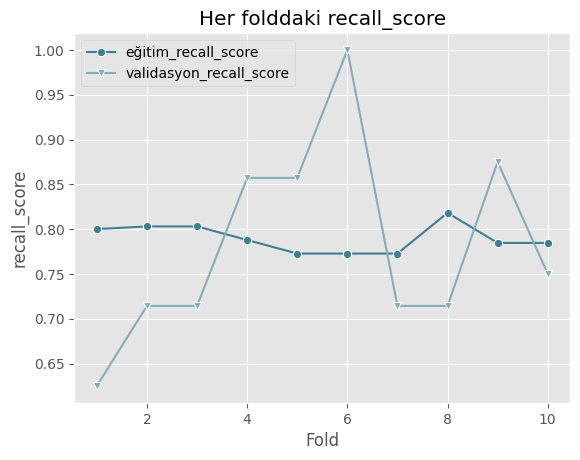

Registered model 'logistic_regression_not_scaled_model' already exists. Creating a new version of this model...
Created version '17' of model 'logistic_regression_not_scaled_model'.


In [2377]:
# grid search sonrası bulunan en iyi parametreler modele eklendi.

best_hyperparams_lr =  {'C': 0.005, 'class_weight': 'balanced', 'penalty': 'l2'}

lr = LogisticRegression(**best_hyperparams_lr, random_state=22)
with mlflow.start_run(run_name="Logistic Regression Not Scaled Model: Metric = recall"):
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
    lr_model, lr_final_test_recall_score, lr_recall_scores_df,lr_y_pred_test = train_and_evaluate_model(lr, X_train, y_train, X_test, y_test,recall_score, skf, plot=True)
    
    # Model metriklerin kaydedilmesi
    mlflow.log_params(best_hyperparams_lr)
    mlflow.log_metric("final_test_recall_score", lr_final_test_recall_score)
    
    # Modelin kaydedilmesi
    model_path = "logistic_regression_not_scaled_model"
    mlflow.sklearn.log_model(lr, model_path)
    
    # Modeli Model Registry'ye kaydetme
    mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name="logistic_regression_not_scaled_model")
    
    # Artifacts kayıt
    lr_recall_scores_df.to_csv("mlflow_model_csv_data/lr_not_scaled_recall_scores.csv", index=False)
    mlflow.log_artifact("mlflow_model_csv_data/lr_not_scaled_recall_scores.csv")

**Scaling ile model eğitim ve değerlendirmesi**

- Ortalama eğitim_recall_score sonuç: 0.88
- Ortalama validasyon_recall_score sonuç: 0.89
- Son test_recall_score sonuç: 0.90
- Validasyon scorunun eğitim scoruna göre farkının % değeri:%1.44
- Final scoreun eğitim scoruna göre farkının % değeri:%2.66
- Son test seti için oluşturulan confusion matrix:
 - [[21  5]
 - [ 1  9]]	
 - Confusion matrixde sadece 1 kişi FN yani yanlış teşhis konulmuş, TP= 9 kişi kalp hastası olarak sınıflandırılmıştır. Model amaca uygun sonuçlar üretmiştir.
  - Burada yazan değerler veriye yeni özellikler eklenmeden oluşturulmuştur.

**Değerlendirme metriği `recall`**

Fold 1 eğitim_recall_score: 0.91
Fold 1 validasyon_recall_score: 0.88
Fold 2 eğitim_recall_score: 0.85
Fold 2 validasyon_recall_score: 1.00
Fold 3 eğitim_recall_score: 0.88
Fold 3 validasyon_recall_score: 0.71
Fold 4 eğitim_recall_score: 0.88
Fold 4 validasyon_recall_score: 0.86
Fold 5 eğitim_recall_score: 0.85
Fold 5 validasyon_recall_score: 1.00
Fold 6 eğitim_recall_score: 0.86
Fold 6 validasyon_recall_score: 0.86
Fold 7 eğitim_recall_score: 0.89
Fold 7 validasyon_recall_score: 0.86
Fold 8 eğitim_recall_score: 0.88
Fold 8 validasyon_recall_score: 0.86
Fold 9 eğitim_recall_score: 0.88
Fold 9 validasyon_recall_score: 1.00
Fold 10 eğitim_recall_score: 0.86
Fold 10 validasyon_recall_score: 0.75
Cross validation aşaması tamamlandı! Model eğitimine başlandı...
*******************************************
Model eğitimi tamamlandı!
*******************************************
Ortalama eğitim_recall_score sonuç: 0.87
Ortalama validasyon_recall_score sonuç: 0.88
Son test_recall_score sonuç: 0.90

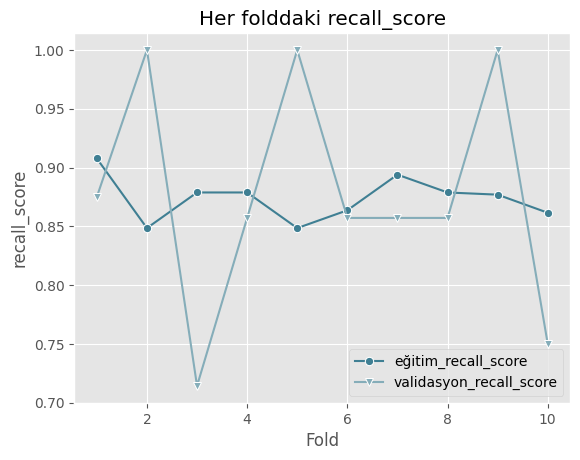

Registered model 'logistic_regression_scaled_model' already exists. Creating a new version of this model...
Created version '17' of model 'logistic_regression_scaled_model'.


In [2378]:
# grid search sonrası bulunan en iyi parametreler modele eklendi.
lr = LogisticRegression(**best_hyperparams_lr, random_state=22)

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", lr)
])

with mlflow.start_run(run_name="Logistic Regression Scaled Model: Metric = recall"):
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
    lr_model, lr_final_test_recall_score, lr_recall_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test,recall_score, skf, plot=True)
    
    # Model metriklerin kaydedilmesi
    mlflow.log_params(best_hyperparams_lr)
    mlflow.log_metric("final_test_recall_score", lr_final_test_recall_score)
    
    # Modelin kaydedilmesi
    model_path = "logistic_regression_scaled_model"
    mlflow.sklearn.log_model(lr_pipeline, model_path)
    
    # Modeli Model Registry'ye kaydetme
    mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name="logistic_regression_scaled_model")
    
    # # Artifacts kayıt
    lr_recall_scores_df.to_csv("mlflow_model_csv_data/lr_scaled_recall_scores.csv", index=False)
    mlflow.log_artifact("mlflow_model_csv_data/lr_scaled_recall_scores.csv")

**Değerlendirme metriği `roc_auc_score`**

Fold 1 eğitim_roc_auc_score: 0.88
Fold 1 validasyon_roc_auc_score: 0.83
Fold 2 eğitim_roc_auc_score: 0.84
Fold 2 validasyon_roc_auc_score: 0.92
Fold 3 eğitim_roc_auc_score: 0.87
Fold 3 validasyon_roc_auc_score: 0.73
Fold 4 eğitim_roc_auc_score: 0.86
Fold 4 validasyon_roc_auc_score: 0.88
Fold 5 eğitim_roc_auc_score: 0.84
Fold 5 validasyon_roc_auc_score: 0.95
Fold 6 eğitim_roc_auc_score: 0.85
Fold 6 validasyon_roc_auc_score: 0.88
Fold 7 eğitim_roc_auc_score: 0.88
Fold 7 validasyon_roc_auc_score: 0.72
Fold 8 eğitim_roc_auc_score: 0.86
Fold 8 validasyon_roc_auc_score: 0.88
Fold 9 eğitim_roc_auc_score: 0.86
Fold 9 validasyon_roc_auc_score: 0.94
Fold 10 eğitim_roc_auc_score: 0.85
Fold 10 validasyon_roc_auc_score: 0.88
Cross validation aşaması tamamlandı! Model eğitimine başlandı...
*******************************************
Model eğitimi tamamlandı!
*******************************************
Ortalama eğitim_roc_auc_score sonuç: 0.86
Ortalama validasyon_roc_auc_score sonuç: 0.86
Son test_ro

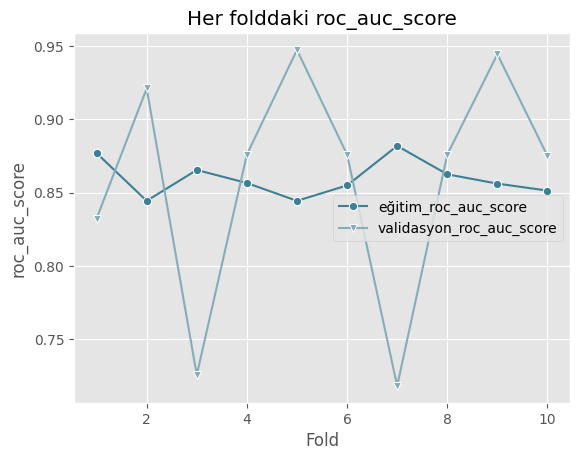

Registered model 'logistic_regression_scaled_model_roc_auc_score' already exists. Creating a new version of this model...
Created version '11' of model 'logistic_regression_scaled_model_roc_auc_score'.


In [2379]:
# grid search sonrası bulunan en iyi parametreler modele eklendi.

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", lr)
])

with mlflow.start_run(run_name="Logistic Regression Scaled Model: Metric = roc_auc_score"):
    
    lr_model, lr_final_test_roc_auc_score, lr_roc_auc_score_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test,roc_auc_score, skf, plot=True)
    
    # Model metriklerin kaydedilmesi
    mlflow.log_params(best_hyperparams_lr)
    mlflow.log_metric("final_test_roc_auc_score", lr_final_test_recall_score)
    
    # Modelin kaydedilmesi
    model_path = "logistic_regression_scaled_model_roc_auc_score"
    mlflow.sklearn.log_model(lr_pipeline, model_path)
    
    # Modeli Model Registry'ye kaydetme
    mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name="logistic_regression_scaled_model_roc_auc_score")
    
    # # Artifacts kayıt
    lr_recall_scores_df.to_csv("mlflow_model_csv_data/lr_scaled_roc_auc_scores.csv", index=False)
    mlflow.log_artifact("mlflow_model_csv_data/lr_scaled_roc_auc_scores.csv")

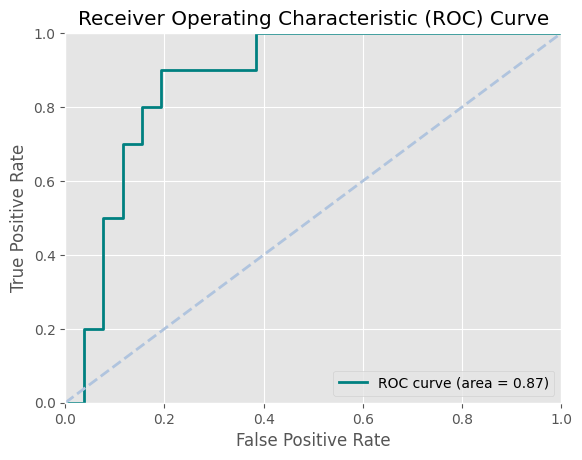

In [2380]:
plot_roc_curve(y_test,lr_y_pred_test)

**Logistic Regression Feature importances tablosu**

- Modelin özelliklerdeki ağırlıklandırmaları tabloda görülmektedir.
- exercise_induced_angina, number_major_vessels,st_depression_induced_by_exercise özelliklerine yüksek positif ağırlık, the normal özelliğine negatif yüksek ağırlık verilmiştir.

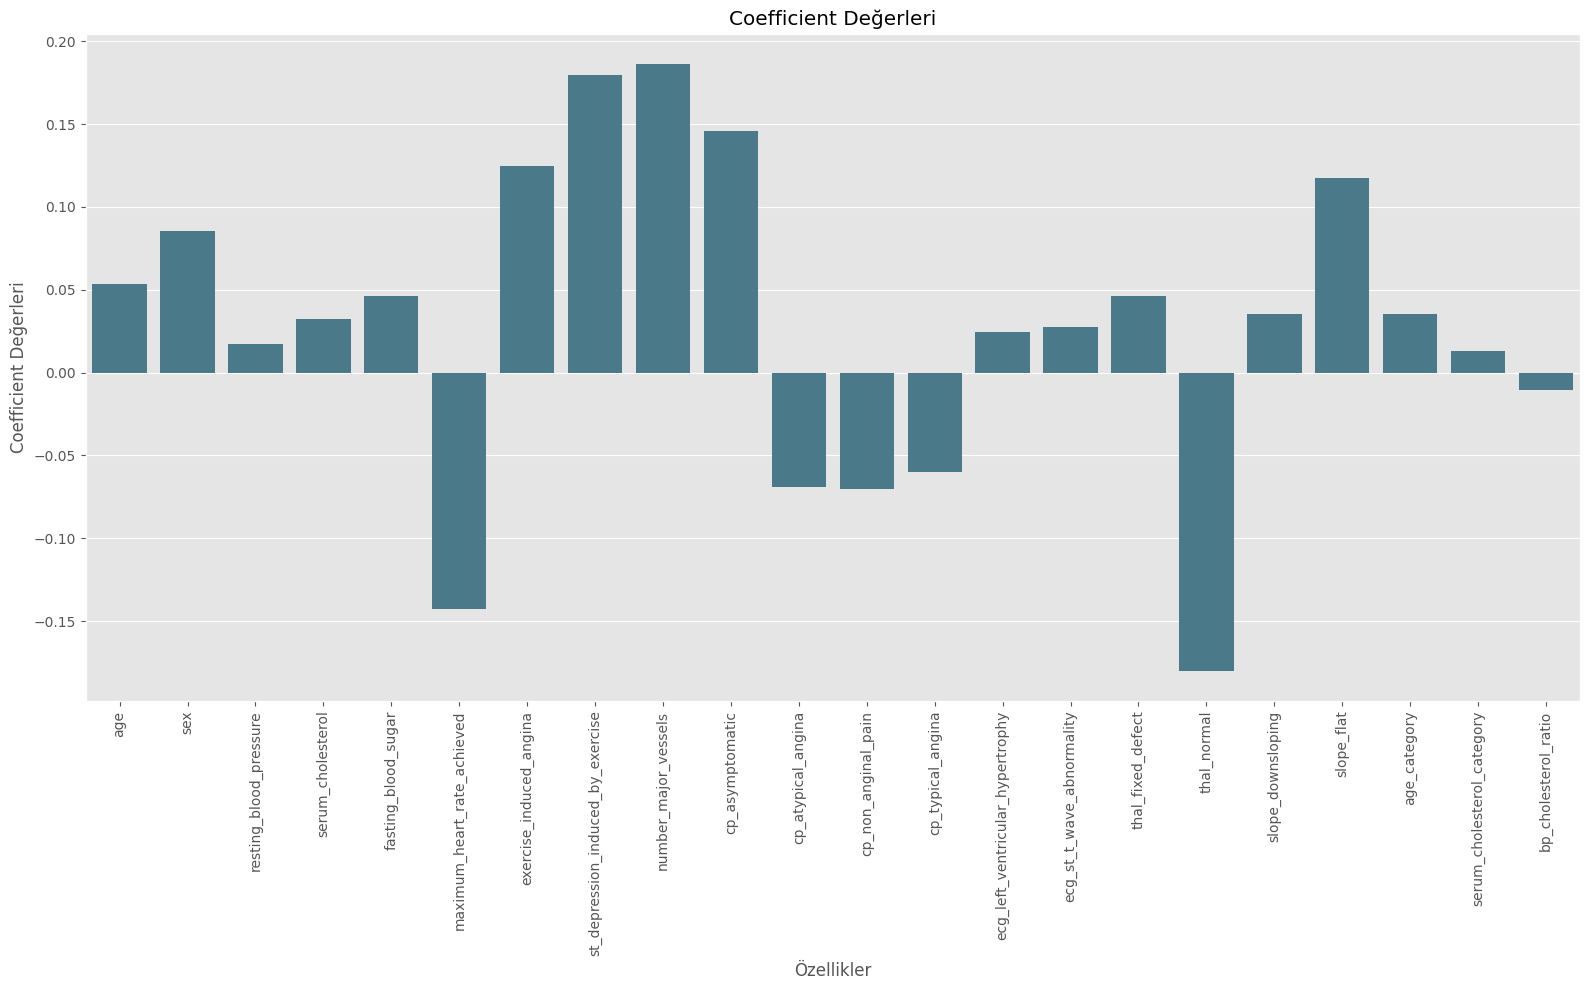

In [2381]:
coef_values = lr_model.named_steps["classifier"].coef_[0]
columns = X_train.columns

plt.figure(figsize=(16, 10))
sns.barplot(x=columns, y=coef_values)
plt.xlabel("Özellikler")
plt.ylabel("Coefficient Değerleri")
plt.title("Coefficient Değerleri")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Random Forest Classifier Modeli**

Ağaç tabanlı modeller, doğal olarak sınıf dengesizliği ve çarpık özelliklerle başa çıkabilir, Ölçekleme gerektirmez ama kullanılmasında bir sakınca olmadığından yine Standar scaler ile ölçeklendirilmiştir. 

- Gridsearch yöntemi ile en iyi parametreleri şu şekilde belirlenmiştir: 'class_weight': 'balanced', 'max_depth': 2, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200
  
`n_estimators:` Ormandaki karar ağaçlarının sayısı. Kullanılan ağaç sayısı arttıkça model daha karmaşık hale gelir ve eğitim süresi uzar. Bu parametre, modelin genel performansını artırabilir ancak aşırı öğrenme riskini de artırabilir.

`max_depth:` Her karar ağacının maksimum derinliği. Daha derin ağaçlar, daha karmaşık modellerin oluşturulmasına izin verir ancak aşırı öğrenme riskini artırır.

`min_samples_split:` Bir iç düğümü bölmek için gereken minimum örnek sayısı. Daha küçük değerler, daha fazla ağaç ve daha karmaşık modellerle sonuçlanabilir.

`min_samples_leaf:` Bir yaprak düğümde bulunması gereken minimum örnek sayısı. Daha küçük değerler, daha karmaşık modellere yol açabilir.

`max_features:` Her karar ağacını bölerken dikkate alınacak maksimum özellik sayısı. Daha yüksek değerler, daha fazla özelliğin kullanımına izin vererek modelin karmaşıklığını artırır.

`class_weight:` Sınıflar arasındaki dengesizlikleri ele almak için kullanılan ağırlıklandırma yöntemi. "balanced" seçeneği, sınıf frekanslarına ters orantılı ağırlıklar kullanır, böylece nadir sınıflar daha fazla ağırlık alır. Bu, dengesiz veri kümelerinde daha iyi performans sağlayabilir.

**Random Forest Classifier hyperparameter tuning**
- Hyperparameter tuning için veri sayısı az olduğundan, brute force yöntemi ile bütün kombinasyonları deneyen Gridsearch kullanılmıştır. 
- Verisayısı ve parametre fazla olduğunda, bu yöntem kullanılamaz hale gelebilir. İşlem süreleri çok uzar. Böyle durumlarda Random search yada bayesian algoritmaları kullanılabilir.
- İşlem 1 saat sürmüştür.

In [2382]:
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
# scoring = make_scorer(recall_score) 
# rf_cv = RandomForestClassifier()

# rf_pipeline_cv = Pipeline([
#     ("scaler", StandardScaler()),
#     ("classifier", rf_cv)
# ])

# params_rf = {
#     "classifier__n_estimators": [ 100, 150, 200, 250, 300],
#     "classifier__max_depth": [None, 2, 4, 6, 8, 12],
#     "classifier__min_samples_split": [1, 2, 5, 10],
#     "classifier__min_samples_leaf": [1, 2, 4, 8],
#     "classifier__max_features": [0.3, 0.5, 0.7, 1],
#     "classifier__class_weight": ["balanced"]
# }

# with mlflow.start_run(run_name="RandomForestClassifier_Grid_Search"):

#     grid_rf = GridSearchCV(estimator=rf_pipeline_cv, param_grid=params_rf, cv=skf, scoring=scoring, verbose=1, n_jobs=1)
#     grid_rf.fit(X,y)
#     best_hyperparams_rf = grid_rf.best_params_
#     best_score_rf = grid_rf.best_score_
#     print("RandomForestClassifier için en iyi hiperparametreler:", best_hyperparams_rf)
#     print("RandomForestClassifier için en iyi score(recall):", best_score_rf)
    
#     # Hyperparametreleri ve en iyi skorların mlflow'a kaydedilmesi
#     mlflow.log_params(best_hyperparams_rf)
#     mlflow.log_metric("lr_best_recall_score", best_score_rf)

```
Fitting 10 folds for each of 1920 candidates, totalling 19200 fits
RandomForestClassifier için en iyi hiperparametreler: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 2, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
RandomForestClassifier için en iyi score(recall): 0.8902777777777778
```

**Model eğitim ve değerlendirmesi**

- Ortalama eğitim_recall_score sonuç: 0.92
- Ortalama validasyon_recall_score sonuç: 0.86
- Son test_recall_score sonuç: 0.90
- Validasyon scorunun eğitim scoruna göre farkının % değeri: -%5.87
- Final scoreun eğitim scoruna göre farkının % değeri: -%1.78
- Son test seti için oluşturulan confusion matrix:
 - [[21  5]
 - [ 1  9]]	
 - Confusion matrixde logistic regression ile aynı sonucu vermiştir., TP= 9 kişi kalp hastası olarak sınıflandırılmıştır.FN = 1 çıkmıştır.
 - Fakat Random forestta validasyon ve test hataları, eğitime göre daha düşüktür. Buda random forest modelinin underfitting yani yetersiz öğrenmenin etkisi olabilir.
 - Veri setinde çok az sayıda veri vardır veri sayısının artırılması gerekmektedir.
 - Burada yazan değerler veriye yeni özellikler eklenmeden oluşturulmuştur.

**Değerlendirme metriği `recall_score`**
- Modelin scale olmayan versiyonu RandomForestClassifier için değerlendirilmeyecektir.

Fold 1 eğitim_recall_score: 0.92
Fold 1 validasyon_recall_score: 1.00
Fold 2 eğitim_recall_score: 0.92
Fold 2 validasyon_recall_score: 1.00
Fold 3 eğitim_recall_score: 0.92
Fold 3 validasyon_recall_score: 1.00
Fold 4 eğitim_recall_score: 0.92
Fold 4 validasyon_recall_score: 0.86
Fold 5 eğitim_recall_score: 0.92
Fold 5 validasyon_recall_score: 0.71
Fold 6 eğitim_recall_score: 0.92
Fold 6 validasyon_recall_score: 0.86
Fold 7 eğitim_recall_score: 0.97
Fold 7 validasyon_recall_score: 0.71
Fold 8 eğitim_recall_score: 0.94
Fold 8 validasyon_recall_score: 0.71
Fold 9 eğitim_recall_score: 0.94
Fold 9 validasyon_recall_score: 0.88
Fold 10 eğitim_recall_score: 0.92
Fold 10 validasyon_recall_score: 0.75
Cross validation aşaması tamamlandı! Model eğitimine başlandı...
*******************************************
Model eğitimi tamamlandı!
*******************************************
Ortalama eğitim_recall_score sonuç: 0.93
Ortalama validasyon_recall_score sonuç: 0.85
Son test_recall_score sonuç: 0.90

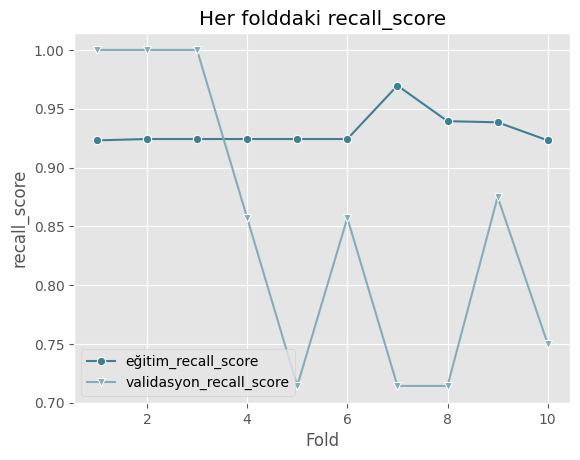

Registered model 'RandomForestClassifier_scaled_model_recall' already exists. Creating a new version of this model...
Created version '34' of model 'RandomForestClassifier_scaled_model_recall'.


In [2384]:
best_hyperparams_rf =  {'class_weight': 'balanced', 'max_depth': 2, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
rf = RandomForestClassifier(**best_hyperparams_rf, random_state=22)

rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", rf)
])

with mlflow.start_run(run_name="RandomForestClassifier Scaled Model: Metric = recall"):
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
    rf_model, rf_final_test_recall_score, rf_recall_scores_df,rf_y_pred_test = train_and_evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test,recall_score, skf, plot=True)
    
    # Model metriklerin kaydedilmesi
    mlflow.log_metric("RandomForestClassifier_final_test_recall_score", rf_final_test_recall_score)
    mlflow.log_params(best_hyperparams_rf)
    
    # Modelin kaydedilmesi
    model_path = "RandomForestClassifier_scaled_model_recall_score"
    mlflow.sklearn.log_model(rf_pipeline, model_path)
    
    # Modeli Model Registry'ye kaydetme
    mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name="RandomForestClassifier_scaled_model_recall")
    
    # # Artifacts kayıt
    rf_recall_scores_df.to_csv("mlflow_model_csv_data/rf_scaled_recall_scores.csv", index=False)
    mlflow.log_artifact("mlflow_model_csv_data/rf_scaled_recall_scores.csv")

**Değerlendirme metriği `roc_auc_score`**

Fold 1 eğitim_roc_auc_score: 0.88
Fold 1 validasyon_roc_auc_score: 0.87
Fold 2 eğitim_roc_auc_score: 0.90
Fold 2 validasyon_roc_auc_score: 0.92
Fold 3 eğitim_roc_auc_score: 0.91
Fold 3 validasyon_roc_auc_score: 0.89
Fold 4 eğitim_roc_auc_score: 0.89
Fold 4 validasyon_roc_auc_score: 0.88
Fold 5 eğitim_roc_auc_score: 0.88
Fold 5 validasyon_roc_auc_score: 0.83
Fold 6 eğitim_roc_auc_score: 0.89
Fold 6 validasyon_roc_auc_score: 0.88
Fold 7 eğitim_roc_auc_score: 0.93
Fold 7 validasyon_roc_auc_score: 0.65
Fold 8 eğitim_roc_auc_score: 0.89
Fold 8 validasyon_roc_auc_score: 0.80
Fold 9 eğitim_roc_auc_score: 0.90
Fold 9 validasyon_roc_auc_score: 0.88
Fold 10 eğitim_roc_auc_score: 0.90
Fold 10 validasyon_roc_auc_score: 0.88
Cross validation aşaması tamamlandı! Model eğitimine başlandı...
*******************************************
Model eğitimi tamamlandı!
*******************************************
Ortalama eğitim_roc_auc_score sonuç: 0.90
Ortalama validasyon_roc_auc_score sonuç: 0.85
Son test_ro

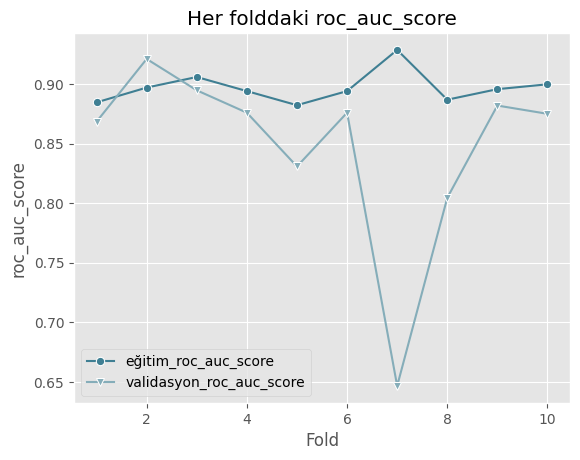

Registered model 'RandomForestClassifier_scaled_model_roc_auc' already exists. Creating a new version of this model...
Created version '10' of model 'RandomForestClassifier_scaled_model_roc_auc'.


In [2385]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", rf)
])

with mlflow.start_run(run_name="RandomForestClassifier Scaled Model: Metric = roc_auc_score"):
    rf_model, rf_final_test_roc_auc_score, rf_roc_auc_scores_df,rf_y_pred_test = train_and_evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test,roc_auc_score, skf, plot=True)
    
    # Model metriklerin kaydedilmesi
    mlflow.log_metric("RandomForestClassifier_final_test_recall_score", rf_final_test_roc_auc_score)
    mlflow.log_params(best_hyperparams_rf)
    
    # Modelin kaydedilmesi
    model_path = "RandomForestClassifier_scaled_model_roc_auc_score"
    mlflow.sklearn.log_model(rf_pipeline, model_path)
    
    # Modeli Model Registry'ye kaydetme
    mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name="RandomForestClassifier_scaled_model_roc_auc")
    
    # # Artifacts kayıt
    rf_roc_auc_scores_df.to_csv("mlflow_model_csv_data/rf_scaled_roc_auc_scores.csv", index=False)
    mlflow.log_artifact("mlflow_model_csv_data/rf_scaled_roc_auc_scores.csv")

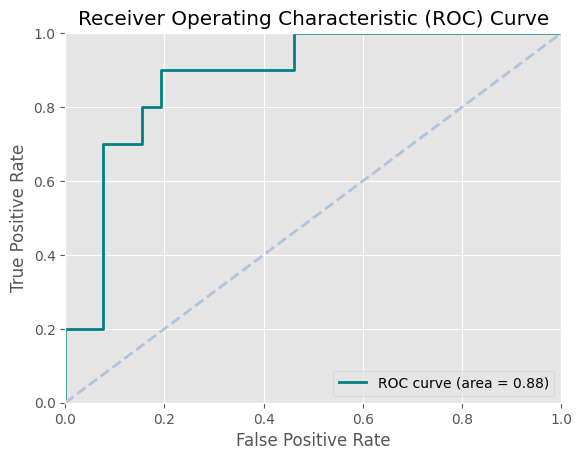

In [2386]:
plot_roc_curve(y_test,rf_y_pred_test)

**RandomForestClassifier Feature importances tablosu**
- Modelin özelliklerdeki ağırlıklandırmaları tabloda görülmektedir.
- Random forest classifier model maximum_heart_rate_achived, st_depression_induced_by_exercise, number_major_vessels, the_normal özelliklerine yüksek önem verdiği görülmektedir.

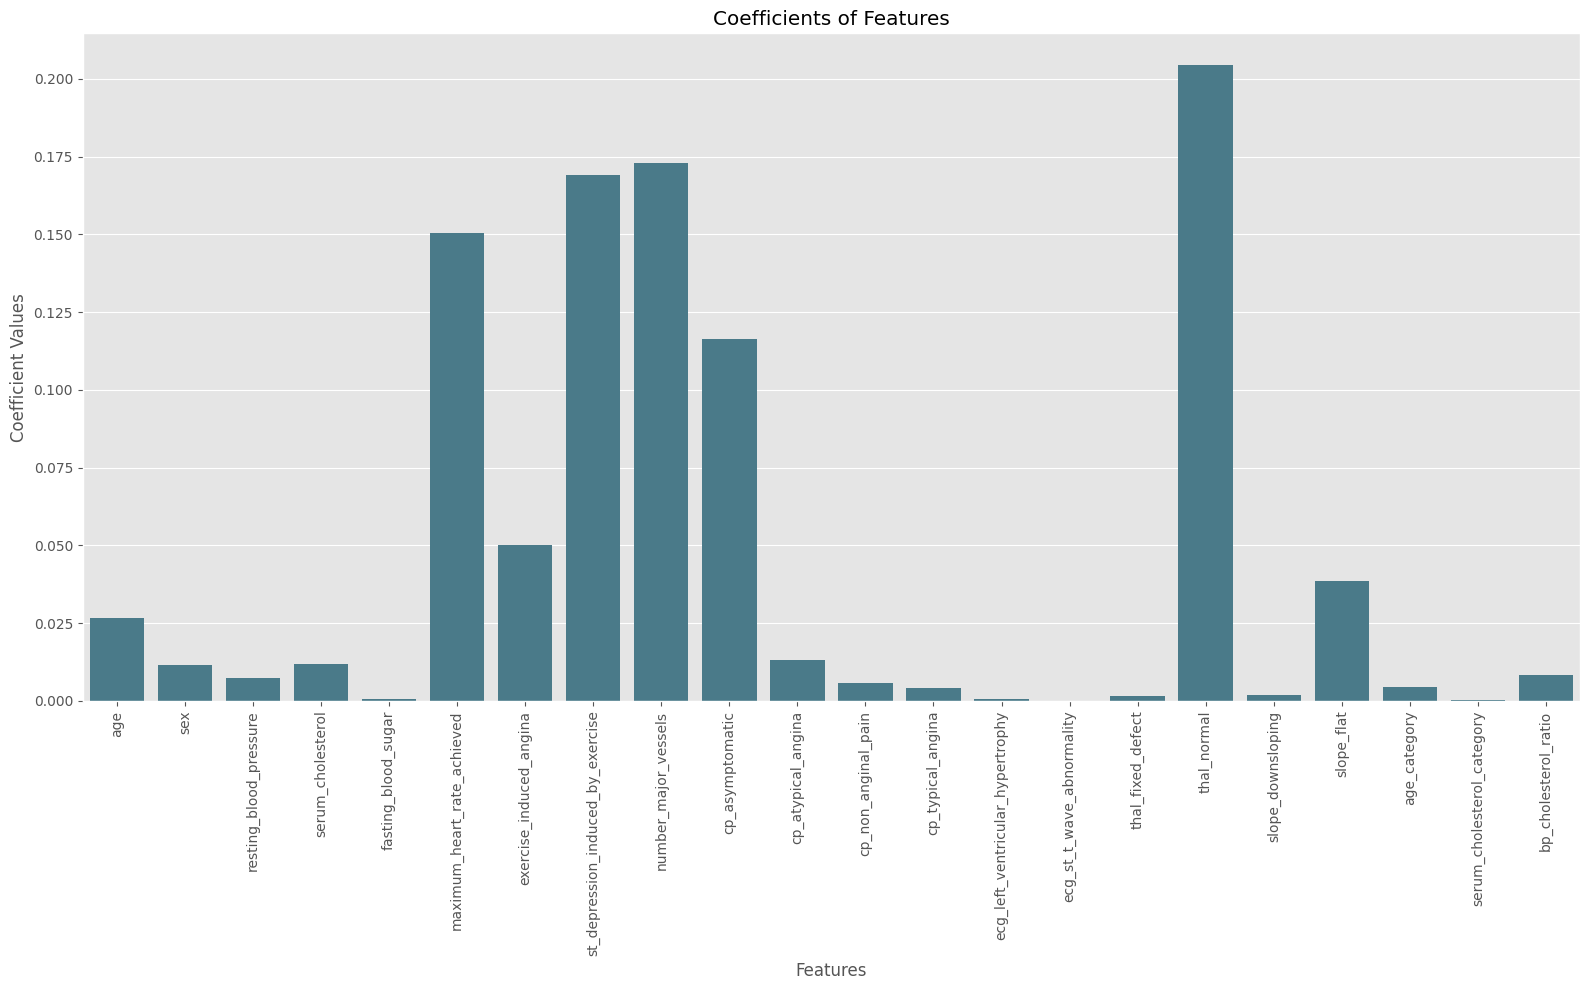

In [2387]:
feature_importances = rf_model.named_steps["classifier"].feature_importances_

columns = X_train.columns
plt.figure(figsize=(16, 10))
sns.barplot(x=columns, y=feature_importances)
plt.xlabel("Features")
plt.ylabel("Coefficient Values")
plt.title("Coefficients of Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Model Seçimi Sonucu**

Kalp hastalığı olabilecek kişileri tespit etmek, bunu yaparkende kalp hastalığı olan kişinin yanlışlıkla sağlıklı diye sınıflandırılması kritik önem taşıdığından `recall` metriği kullanılmıştır.
İlave olarak modelin sınıfları ne kadar iyi ayırlığının bir ölçüsü olarakda `roc_auc_score` ile çift taraflı bir kontrol yapılmıştır.

Sonuç olarak, model seçiminde 2 performans metriği recall ve roc_auc_score üzerinden değerlendirme yapılmıştır.

Logistic regression  ve Random forest modellerinin aldığı  recall ve roc_auc_score değerleri aşağıdaki gösterilmiştir.

Modeller benzer performans göstermiştir. RandomForest Classifier modelinin eğitim sırasında özellik seçimi yapma özelliğinden dolayı final model olarak Random forest Classifier modeli tercih edilmiştir.

**Modellerin performans metriklerinin karşılaştırılması**

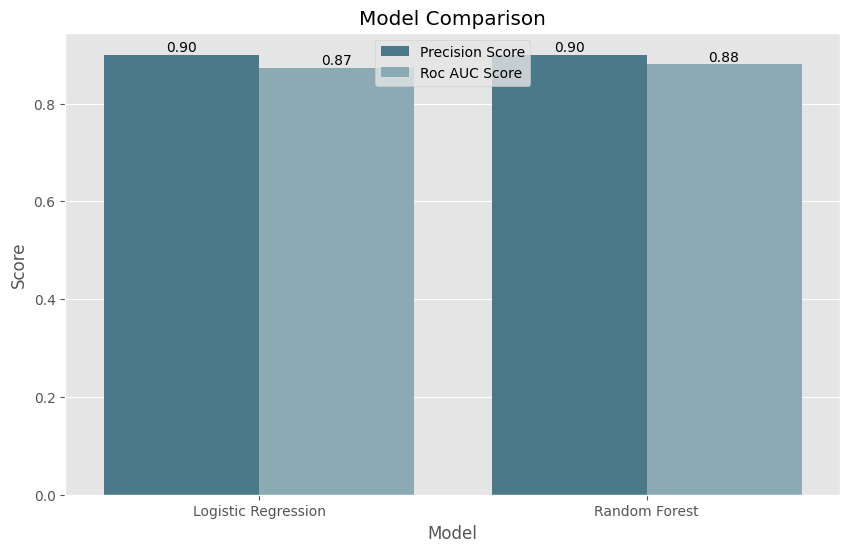

In [2388]:
scores_data = {
    "Model": ["Logistic Regression"] * 2 + ["Random Forest"] * 2,
    "Metric": ["Precision Score", "Roc AUC Score"] * 2,
    "Score": [lr_final_test_recall_score, lr_final_test_roc_auc_score, rf_final_test_recall_score, rf_final_test_roc_auc_score]
}
scores_df = pd.DataFrame(scores_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Score", hue="Metric", data=scores_df)
for container in ax.containers:
    ax.bar_label(container, fmt='%0.2f', label_type="edge")
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc="upper center")
plt.show()

**Modellerin seçtiği özelliklerin karşılaştırılması**
- Buradaki grafik 2 modelinde seçtiği özellikleri aynı ölçeğe indirerek seçimlerinin karşılaştırmasını tek grafik üzerinde görmektir.
- Karşılaştırma yaparken random forest classifier modelinin özelliklere negatif ağırlık vermediği göz önünde bulundurulmalıdır.
- İki modelinde genel olarak benzer özellikleri seçtiği görülmektedir.

In [2389]:
feature_dict = {"Özellikler":X_train.columns,"Logistic Regression Özellikleri": coef_values, "RandomforestClassifier Özellikleri": feature_importances}
models_features_df = pd.DataFrame(feature_dict)
models_features_df.set_index("Özellikler",inplace=True)

scaler = MinMaxScaler()
models_features_df_scaled =scaler.fit_transform(models_features_df)
df_scaled_features = pd.DataFrame(models_features_df_scaled, columns=models_features_df.columns, index=models_features_df.index)

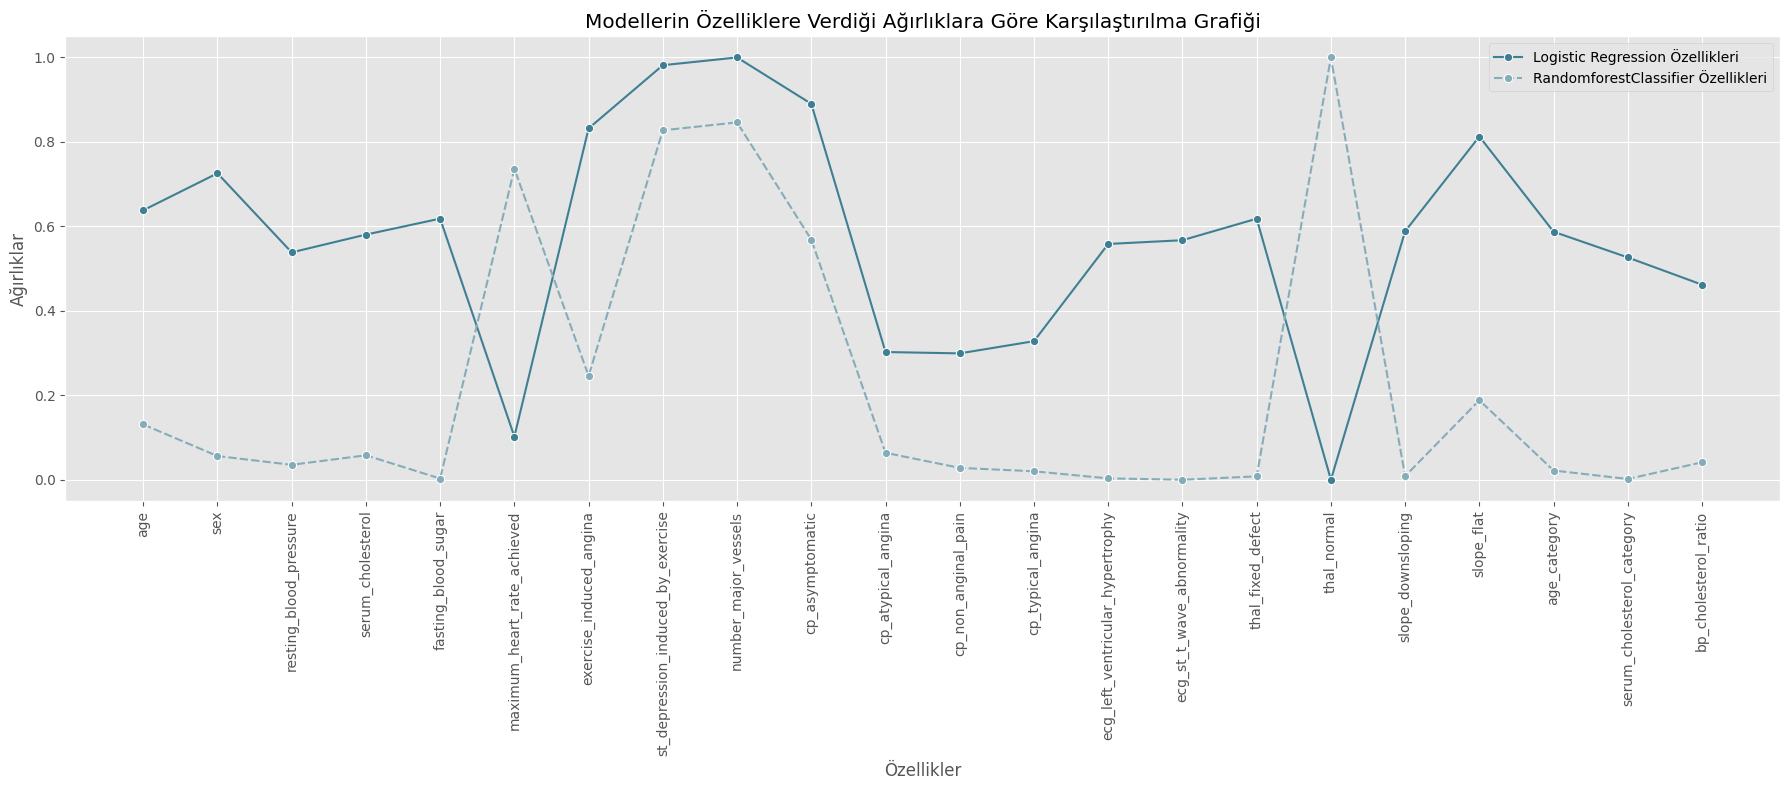

In [2390]:
plt.figure(figsize=(18, 8))
sns.lineplot(df_scaled_features, markers="o")
plt.title("Modellerin Özelliklere Verdiği Ağırlıklara Göre Karşılaştırılma Grafiği")
plt.xlabel("Özellikler")
plt.ylabel("Ağırlıklar")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# MODEL PIPELINE OLUŞTURMA VE MODEL DEPLOYMENT:

- Veri seti üzerinde yapılan bütün işlemler sklearn pipeline haline getirilmiştir. Bunun nedeni gerçek hayatta tahmin edilecek veriler ham halde gelir bu nedenle bu süreci yönetmek için pipeline oluşturulmuştur. Her yapılan işlem sklearn BaseEstimator classından inherit edilerek modÜler bir yapı oluşturulmuştur. 
- Model bütün veriyi işleyecek şekilde mlflow ile kaydedimiştir. 
- Gradio ve fast api kütüphanelerinin yardımı ile fronthand ve backend işlemleri yapılıp proje uygulama haline getirilmiştir. 

In [2408]:
# Aykırı değerlerin tespit edilip baskılanması
class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for variable in self.variables:
            low_limit, up_limit = self.outlier_thresholds(X, variable)
            X.loc[(X[variable] > up_limit), variable] = up_limit
            if X[variable].min() > 0:
                X.loc[(X[variable] < low_limit), variable] = low_limit
        return X

    def outlier_thresholds(self, X, variable, q1_thr=0.25, q3_thr=0.75):
        quartile1 = X[variable].quantile(q1_thr)
        quartile3 = X[variable].quantile(q3_thr)
        interquantile_range = quartile3 - quartile1
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile1 - 1.5 * interquantile_range
        return low_limit, up_limit

# Özellik üretim klası  
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Age category özelliğinin oluşturulması
        age_bins = [-np.inf, 18, 40, 60, np.inf]
        age_labels = [0, 1, 2, 3]
        X['age_category'] = pd.cut(X['age'], bins=age_bins, labels=age_labels)
        
        # Serum category özelliğinin oluşturulması
        mhr_bins = [-np.inf, 100, 200, 300, np.inf]
        mhr_labels = [0, 1, 2, 3]
        X['serum_cholesterol_category'] = pd.cut(X['serum_cholesterol'], bins=mhr_bins, labels=mhr_labels)
        
        # bp_cholesterol_ratio özelliğinin oluşturulması
        X['bp_cholesterol_ratio'] = X['resting_blood_pressure'] / X['serum_cholesterol']
        
        return X

# Korelasyonları belirleyip eşik değer üzerindekini drop eden class
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.85):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        # Veri numpy array gelirse hata çıktığından dolayı daraframe e çevriliyor
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        elif not isinstance(X, pd.DataFrame):
            raise ValueError("X, bir Pandas DataFrame olmalıdır.")
        
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        elif not isinstance(X, pd.DataFrame):
            raise ValueError("X, bir Pandas DataFrame olmalıdır.")
        
        return X.drop(columns=self.to_drop, errors='ignore')
    
    
one_hot_cat_features = ["chest_pain_type", "resting_ecg_results", "thal","slope_peak_exercise_st_segment"]
ordinal_age_cat_features = ["age_category"]
ordinal_serum_cat_features = ["serum_cholesterol_category"]
numerical_features = ["age", "resting_blood_pressure", "serum_cholesterol", "maximum_heart_rate_achieved", "st_depression_induced_by_exercise", "number_major_vessels","bp_cholesterol_ratio"]
outlier_features = ["age", "resting_blood_pressure", "serum_cholesterol", "maximum_heart_rate_achieved", "st_depression_induced_by_exercise"]

one_hot_cat_transformer = OneHotEncoder()
ordinal_cat_trainsformer = OrdinalEncoder(categories=[[0, 1, 2, 3]])
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_ohe', one_hot_cat_transformer, one_hot_cat_features),
        ('age_cat_ord', ordinal_cat_trainsformer, ordinal_serum_cat_features),
        ('serum_cat_ord', ordinal_cat_trainsformer, ordinal_serum_cat_features),
    ],
    remainder='passthrough' # belirtilmeyen sütünlar geçilir.
)

pipeline = Pipeline(steps=[
    ('outlier_replacer', OutlierReplacer(variables=outlier_features)),
    ('feature_generator', FeatureGenerator()),
    ('preprocessor', preprocessor),
    ('correlation_filter', CorrelationFilter(threshold=0.82)),
    ('classifier', RandomForestClassifier(**best_hyperparams_rf,random_state=22))
])

# Modelin eğitim aşaması
def train_and_log_model(X, y):
    with mlflow.start_run(run_name="RandomForestClassifier Production Model: Metric = recall"):
        pipeline.fit(X, y)
        model_path = "final_rf_model"
        mlflow.log_params(best_hyperparams_rf)
        mlflow.sklearn.log_model(pipeline, model_path)
        mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name=model_path)
        

In [2403]:
# pipeline listesinin son elamanı modeli içeriyor
pipeline[-1]

RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=0.3,
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=22)

In [2409]:
df = pd.read_csv("raw_heart_disease_data.csv")
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
0,63,1,cp_typical_angina,145,233,1,ecg_left_ventricular_hypertrophy,150,0,2.3,slope_downsloping,0.0,thal_fixed_defect,0
1,67,1,cp_asymptomatic,160,286,0,ecg_left_ventricular_hypertrophy,108,1,1.5,slope_flat,3.0,thal_normal,1
2,67,1,cp_asymptomatic,120,229,0,ecg_left_ventricular_hypertrophy,129,1,2.6,slope_flat,2.0,thal_reversable_defect,0
3,37,1,cp_non_anginal_pain,130,250,0,ecg_normal,187,0,3.5,slope_downsloping,0.0,thal_normal,0
4,41,0,cp_atypical_angina,130,204,0,ecg_left_ventricular_hypertrophy,172,0,1.4,slope_upsloping,0.0,thal_normal,0


**Veriyi ham halde modele vereceğimizden dolayı ilk temizleme aşaması manuel yapılmıştır**

In [2410]:
df.dropna(inplace=True)

In [2411]:
target = "presence_of_heart_disease"
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12,stratify=y, random_state=42)

In [2412]:
train_and_log_model(X_train, y_train)

Registered model 'final_rf_model' already exists. Creating a new version of this model...
Created version '11' of model 'final_rf_model'.


**Değişikliklerin Uygulanmasının kontrolü**
- Aykırı değer analizinin yapıldığı ve yeni özelliklerin eklendiği görülmüştür.

In [2413]:
low_limit, up_limit = outlier_thresholds(X_train, "resting_blood_pressure")
show_outliers(X_train,"resting_blood_pressure", low_limit, up_limit)


low_limit: 90.0, up_limit: 170.0
Veri setinde 9 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal
201,64,0,cp_asymptomatic,180,325,0,ecg_normal,154,1,0.0,slope_upsloping,0.0,thal_normal
126,56,0,cp_asymptomatic,200,288,1,ecg_left_ventricular_hypertrophy,133,1,4.0,slope_downsloping,2.0,thal_reversable_defect
231,55,0,cp_asymptomatic,180,327,0,ecg_st_t_wave_abnormality,117,1,3.4,slope_flat,0.0,thal_normal
183,59,1,cp_typical_angina,178,270,0,ecg_left_ventricular_hypertrophy,145,0,4.2,slope_downsloping,0.0,thal_reversable_defect
172,59,0,cp_asymptomatic,174,249,0,ecg_normal,143,1,0.0,slope_flat,0.0,thal_normal


In [2414]:
X_transformed = pipeline.named_steps['outlier_replacer'].transform(X_train)
X_transformed = pipeline.named_steps['feature_generator'].transform(X_transformed)
# X_transformed = pipeline.named_steps['preprocessor'].transform(X_transformed)
# X_transformed = pipeline.named_steps['correlation_filter'].transform(X_transformed)
low_limit, up_limit = outlier_thresholds(X_transformed, "resting_blood_pressure")
show_outliers(X_transformed,"resting_blood_pressure", low_limit, up_limit)

low_limit: 90.0, up_limit: 170.0
Veri setinde 0 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,age_category,serum_cholesterol_category,bp_cholesterol_ratio


In [2426]:
# sklearn kütüphanesi için model yükleme
model_path = "models:/final_rf_model/11" 
model = mlflow.sklearn.load_model(model_path)

# diğer genel yükleme yöntemi
# model_path = "models:/final_rf_model/7" 
# model = mlflow.pyfunc.load_model(model_path)

In [2416]:
y_pred_final = model.predict(X_test)
final_recall_core = recall_score(y_test, y_pred_final)
print(f"Test Recall: {final_recall_core:.4f}")

Test Recall: 0.9000


In [2417]:
y_pred_prob_final = model.predict_proba(X_test)[:,1]
final_roc_auc_score = roc_auc_score(y_test, y_pred_prob_final)
print(f"Test roc_auc_score: {final_roc_auc_score}")

Test roc_auc_score: 0.8884615384615384


**Test tahmini:**

In [2423]:
sample_data1 = X_test.iloc[0:1]
sample_data2 = X_test.iloc[1:2]

In [2427]:
sample_data1

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal
143,64,1,cp_non_anginal_pain,125,309,0,ecg_normal,131,1,1.8,slope_flat,0.0,thal_reversable_defect


In [2424]:
predicted_class = model.predict(sample_data1)
predicted_class

array([1], dtype=int64)

In [2425]:
predicted_class = model.predict(sample_data2)
predicted_class

array([0], dtype=int64)

# SONUÇ VE ÖNERİLER

- Modelin daha iyi tahminler üretmesi için veri sayısının artırılması gerekmektedir.
- Tıbbi litaratür araştırması yapılıp gerekirse uzman doktorlar ile görüşülerek modele yeni özellikler eklenebilir.
- Yeni özellikler eklendikten sonra powerBI gibi yapılar kullanılarak daha detaylı veri analizi yapılıp ilişkiler ortaya konabilir. Kalp sağlığı konusunda akla gelmeyen yeni sebepler keşfedilebilir.
- Bu projede oluşturulan yapı ayrı py dosyalarına kaydedilip dvc, hydra gibi kütüphaneler ile daha yönetilebilir hale gelebilir.Github actions, jenkins gibi CI/CD yapıları ile Mlops süreçleri daha fazla otomatize edilebilir.
- Model cloud platformlara taşınabilir. Örnek olarak AWS vpc içerisinde gerekli network altyapısı kurularak ec2, s3, lambda, APIgateway, dynamodb ve Sagemaker servisleri kulanılarak bulut platformlarda otomatize şekilde yayınlanabilir. 
- Tahmin sonuçları database'e yazılabilir.
- Modelin hazırlanması profesyonel olarak tamamlandığında tahmin performansı sürekli izlenip data drift vs gibi durumların önüne geçilebilir.
- Modelin ürün haline getirilmesi durumunda frontend olarak react, vue.js gibi yapılar backend olarak node.js, .net gibi yapılar ile daha profesyonel ortama taşınabilir.